### Summary

__The following steps were taken to clean the data:__
- `sex and age`, `job_status and living_area` 
    - both were were separated into individual columns
    - attributes that were entered in the wrong order were swapped around
    - `age` was floored to an integer, and strings mapped to appropriate integers
    - undecipherable features were dropped
- NaN values or any other undecipherable values in the binary columns were dropped
- The float columns (sugar and BMI) were changed to floats, undecipherable values dropped 

__Other considerations:__
- removing outliers
    - a quick plot indicates there are no clearly identifiable outliers by eye
    - we will test the model performance with and without removing outliers (keep 95% of data)
- normalisation of data
- imbalanced dataset
    - regardless of what we do, this imbalanced dataset will pose problems
    - we will likely upsample the minority class
    
The processed dataset was saved to `train_processed.csv`.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
stk = pd.read_csv("../data/train.csv")
stk.head()

id sex and age high_BP heart_condition_detected_2017 married  \
0  16053       F, 61       1                             0       1   
1   1459       F, 30       0                             0       0   
2   7678       F, 51       1                             0       1   
3  34943       F, 54       0                             0       1   
4  17741       M, 27       0                             0       0   

  job_status and living_area  average_blood_sugar   BMI  smoker_status  \
0          government?Remote                71.67  36.6     non-smoker   
1      Remote?private_sector               107.95  30.4           quit   
2          government?Remote                76.49  42.1  active_smoker   
3            government?City               113.98  57.3           quit   
4        private_sector?City                70.60  26.7  active_smoker   

   TreatmentA  TreatmentB  TreatmentC TreatmentD stroke_in_2018  
0         NaN         NaN         NaN        NaN              0  
1         NaN         NaN         NaN        NaN              0  
2         NaN         NaN         NaN        NaN              0  
3         NaN         NaN         NaN        NaN              0  
4         NaN         NaN         NaN        NaN              0

In [3]:
stk["stroke_in_2018"].value_counts()

0       34179
1         652
.           3
,           1
N?A         1
?           1
nuLL        1
Name: stroke_in_2018, dtype: int64

<div class="alert alert-block alert-warning">
Highly Imbalanced Dataset!
</div>

In [4]:
stk.columns

Index(['id', 'sex and age', 'high_BP', 'heart_condition_detected_2017',
       'married', 'job_status and living_area', 'average_blood_sugar', 'BMI',
       'smoker_status', 'TreatmentA', 'TreatmentB', 'TreatmentC', 'TreatmentD',
       'stroke_in_2018'],
      dtype='object')

In [5]:
stk.shape

(34872, 14)

In [6]:
stk["job_status and living_area"].unique()

array(['government?Remote', 'Remote?private_sector', 'government?City',
       'private_sector?City', 'private_sector?Remote',
       'business_owner?Remote', 'parental_leave?Remote',
       'parental_leave?City', 'business_owner?City',
       'City?private_sector', 'private sector?Remote',
       'Remote?business_owner', 'City?business_owner',
       'Remote?government', 'City?government', 'City?parental_leave',
       'Remote?parental_leave', 'unemployed?City', 'unemployed?Remote',
       'private_sector?c', 'private_sector?', 'business_owner?cIty',
       'govt.?Remote', 'private_sector?CITY', nan, 'City?unemployed',
       'PARENTAL LEAVE?City', '?Remote', 'remote?private_sector',
       'cIty?private_sector', 'GOVERNMENT?Remote', '?City',
       'private?City', 'NULL?City', 'cIty?government',
       'private_sector?NULL', 'Remote?unemployed',
       'PRIVATE sector?Remote', 'remotee?private_sector',
       'parental_leave?REMOTE', 'government?CITY', 'r?private_sector',
       'cit

In [7]:
stk["sex and age"].unique()

array(['F, 61', 'F, 30', 'F, 51', 'F, 54', 'M, 27', nan, 'M, 63', 'M, 55',
       'F, 37', 'M, 49', 'M, 28', 'F, 68', 'M, 61', 'F, 6', 'M, 48',
       'F, 36', 'M, 53', 'M, 72', 'M, 64', 'F, 71', 'M, 54', 'M, 34',
       '76, F', 'M, 16', 'M, 31', 'F, 66', 'M, 74', 'M, 59', 'M, 52',
       'M, 43', 'F, 76', 'F, 16', 'F, 15', 'F, 32', 'F, 64', 'F, 52',
       'F, 27', 'M, 17', 'M, 79', 'F, 5', 'F, 39', 'F, 34', 'M, 83',
       'M, 8', 'M, 15', 'M, 6', 'F, 82', 'M, 11', 'M, 30', '8, F',
       'F, 38', 'F, 25', 'F, 40', 'F, 80', 'M, 32', 'M, 77', 'M, 60',
       'F, 42', 'M, 35', 'F, 55', 'F, 74', 'M, 19', 'M, 70', 'F, 85',
       'M, 73', 'F, 57', 'M, 67', 'M, 25', 'M, 39', 'M, 37', 'F, 72',
       'F, 59', 'M, 40', 'F, 73', 'F, 11', 'F, 50', 'F, 53', 'F, 35',
       'F, 33', 'M, 69', 'F, 78', 'F, 17', 'F, 69', 'M, 22', 'F, 13',
       '17, F', 'M, 62', 'M, 65', 'M, 58', 'M, 82', 'F, 43', 'F, 44',
       '18, F', '59, F', 'M, 36', 'M, 76', 'M, 50', 'M, 38', 'M, 3.24',
       '43, F', 'F

Looks like there are some variables that need to be wrangled.

### Data Wrangling

In [66]:
def split_row(row, sep):
    """Given a string split by sep and return a tuple."""
    x = str(row).split(sep=sep)
#     print(x)
    if len(x) == 1:
        return str(x[0])
    else:
        return str(x[0]), str(x[1])
    
def split_tup(row):
    """Split the tuple to be inserted into 2 Pandas series"""
    if len(row) == 1:
        return row[0]
    else:
        return row[0], row[1]   
    
# Because the conditions differ slightly, I wrote 2 separate functions

def swap_job_living(job, area):
    """ 
    Check if job_status and living_area have been incorrectly entered. 
    If so swap the values into the other column. 
    """
    print("job: {}\narea: {}".format(job, area))
    if (job in living_area_correct) & (area in job_status_correct):
        print("swap")
        return area, job
    else:
        print("don't swap")
        return job, area
    
def swap_sex_age(sex, age):
    """ 
    Check if age contains 'm' or 'f' we swap the values in the columns. 
    """
    print("sex: {}\nage: {}".format(sex, age))
    if (age in sex_correct):
        print("swap")
        return age, sex
    else:
        print("don't swap")
        return sex, age

#### Testing of functions

In [9]:
split_row(row='F, 61', sep=",")

('F', ' 61')

## Wrangling Begins Here

<div class="alert alert-block alert-info">
Check Job status and living area
</div>

In [10]:
stk["job_status_living_area"] = stk["job_status and living_area"].apply(split_row, args="?")
stk["job_status_living_area"].head()

id sex and age high_BP heart_condition_detected_2017 married  \
0  16053       F, 61       1                             0       1   
1   1459       F, 30       0                             0       0   
2   7678       F, 51       1                             0       1   
3  34943       F, 54       0                             0       1   
4  17741       M, 27       0                             0       0   

  job_status and living_area  average_blood_sugar   BMI  smoker_status  \
0          government?Remote                71.67  36.6     non-smoker   
1      Remote?private_sector               107.95  30.4           quit   
2          government?Remote                76.49  42.1  active_smoker   
3            government?City               113.98  57.3           quit   
4        private_sector?City                70.60  26.7  active_smoker   

   TreatmentA  TreatmentB  TreatmentC TreatmentD stroke_in_2018  \
0         NaN         NaN         NaN        NaN              0   
1         NaN         NaN         NaN        NaN              0   
2         NaN         NaN         NaN        NaN              0   
3         NaN         NaN         NaN        NaN              0   
4         NaN         NaN         NaN        NaN              0   

     job_status_living_area  
0      (government, Remote)  
1  (Remote, private_sector)  
2      (government, Remote)  
3        (government, City)  
4    (private_sector, City)

In [67]:
stk['job_status'], stk['living_area'] = zip(*stk['job_status_living_area'].map(split_tup))
stk[["job_status_living_area", "job_status", "living_area"]].head()

job_status_living_area      job_status     living_area
0      (government, Remote)      government          Remote
1  (Remote, private_sector)          Remote  private_sector
2      (government, Remote)      government          Remote
3        (government, City)      government            City
4    (private_sector, City)  private_sector            City

---
__Living Area__
---

Make everything lowercase, remove weird variables, and correct spelling

In [12]:
stk["living_area"] = stk["living_area"].apply(lambda x: x.lower())

In [13]:
print(stk["living_area"].value_counts())
print(stk["living_area"].unique())

city              15149
remote            15078
private_sector     2603
business_owner      710
parental_leave      655
government          616
a                    31
unemployed           22
                      3
null                  2
c                     1
privattte             1
biz                   1
Name: living_area, dtype: int64
['remote' 'private_sector' 'city' 'business_owner' 'government'
 'parental_leave' 'c' '' 'a' 'unemployed' 'null' 'privattte' 'biz']


In [14]:
stk.loc[stk["living_area"] == "privattte", "living_area"] = "private_sector"
print(stk["living_area"].value_counts())

city              15149
remote            15078
private_sector     2604
business_owner      710
parental_leave      655
government          616
a                    31
unemployed           22
                      3
null                  2
c                     1
biz                   1
Name: living_area, dtype: int64


In [15]:
stk[stk["living_area"] == "government"]

id sex and age high_BP heart_condition_detected_2017 married  \
65     24350       M, 49       0                             0       1   
80     25783       M, 39       0                             0       0   
112     1006       F, 36       0                             0       1   
136    25526       M, 38       0                             0       0   
168     2541       F, 51       0                             0       1   
205     2215       M, 65       0                             0       0   
322    25063       F, 76       0                             0       1   
329    25991       F, 45       0                             0       1   
511     3684       M, 35       1                             0       0   
563    25336       F, 58       0                             0       1   
564     3245       F, 66       0                             0       1   
580     2537       M, 20       0                             0       0   
584    24707       M, 76       1                             0       1   
632     2845       F, 55       0                             0       1   
644     1035       M, 66       0                             0       1   
799    25612       F, 52       0                             0       1   
816     1524       M, 54       0                             0       1   
843     2909       M, 61       0                             0       1   
970    24539       M, 68       0                             1       1   
1021    1046       F, 65       0                             0       1   
1082   25085       F, 49       0                             0       1   
1089   24604       F, 70       0                             0       1   
1151   25838       F, 53       0                             0       1   
1183   25598       M, 55       0                             0       1   
1209     988       F, 35       0                             0       0   
1277    1245       M, 71       1                             0       1   
1282     535       F, 34       0                             0       1   
1302    2040       F, 46       0                             0       0   
1453    2982       F, 40       0                             0       0   
1465    1990       F, 63       0                             0       1   
...      ...         ...     ...                           ...     ...   
33041    568       F, 54       0                             0       0   
33124    905       M, 65       0                             0       1   
33136    610       F, 56       0                             0       1   
33153   1509       M, 66       0                             0       1   
33335    956       M, 46       0                             0       1   
33405  25880       M, 24       0                             0       0   
33421  24527       F, 52       0                             0       1   
33519  24026       F, 57       0                             0       1   
33561   1290       M, 78       0                             0       1   
33592    430       M, 43       0                             0       1   
33659   2522       F, 61       1                             0       1   
33844   3705       M, 40       0                             0       1   
34164   3585       F, 41       0                             0       1   
34283  25680       F, 28       0                             0       0   
34351   2863       F, 43       0                             0       0   
34372    361       F, 42       0                             0       1   
34472  25265       F, 59       0                             0       1   
34473  25894       M, 41       0                             0       1   
34522  24325       F, 38       0                             0       1   
34544   3963       M, 69       0                             1       0   
34599  25825       F, 29       0                             0       0   
34604   2818       F, 29       0                             0       1   
34607   2910  

<div class="alert alert-block alert-warning">
It appears that living_area and job_status are sometimes filled in the wrong columns
</div>

Hence, we need to write a function to swap them.

But before we do that, we designate the variables we want to keep.

In [16]:
living_area_keep = ["city", "remote", "private_sector", "business_owner",
                    "parental_leave", "government", "unemployed"]

In [17]:
stk = stk[(stk["living_area"].isin(living_area_keep))]
stk.shape

(34834, 17)

---
__Job status__
---

We take a similar approach to the `job_status`.

In [18]:
stk["job_status"] = stk["job_status"].apply(lambda x: x.lower())

In [19]:
print(stk["job_status"].value_counts())
print(stk["job_status"].unique())

private_sector    17271
business_owner     4772
parental_leave     4263
government         3767
city               2303
remote             2300
unemployed          120
private sector       16
govt.                 4
null                  4
parental leave        3
                      3
biz                   2
remotee               1
business owner        1
private               1
c                     1
r                     1
n.a                   1
Name: job_status, dtype: int64
['government' 'remote' 'private_sector' 'business_owner' 'parental_leave'
 'city' 'private sector' 'unemployed' 'govt.' 'parental leave' ''
 'private' 'null' 'remotee' 'r' 'n.a' 'business owner' 'biz' 'c']


In [20]:
stk.loc[stk["job_status"] == "parental leave", "job_status"] = "parental_leave"
stk.loc[stk["job_status"] == "private sector", "job_status"] = "private_sector"
stk.loc[stk["job_status"] == "private", "job_status"] = "private_sector"
stk.loc[stk["job_status"] == "govt.", "job_status"] = "government"
stk.loc[stk["job_status"] == "remotee", "job_status"] = "remote"
print(stk["job_status"].value_counts())

private_sector    17288
business_owner     4772
parental_leave     4266
government         3771
city               2303
remote             2301
unemployed          120
null                  4
                      3
biz                   2
c                     1
business owner        1
n.a                   1
r                     1
Name: job_status, dtype: int64


In [21]:
# Variables to be dropped
job_status_keep = ["private_sector", "business_owner", "parental_leave", 
                   "government", "city", "remote", "unemployed"]

In [22]:
stk = stk[(stk["job_status"].isin(job_status_keep))]
stk.shape

(34821, 17)

__Now let's swap the variables around__

In [23]:
job_status_correct = ["private_sector", "business_owner", "parental_leave", 
                   "government", "unemployed"]
living_area_correct = ["city", "remote"]

In [24]:
stk["job_status_corr"], stk["living_area_corr"] = zip(*stk.apply(lambda x:\
            swap_job_living(x.job_status, x.living_area), axis=1))

job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: government
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don

job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_s

area: remote
don't swap
job: city
area: government
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: city
area: business_owner
swap
job: government
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
jo

job: city
area: parental_leave
swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: ci

area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: unemployed
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: city
area: government
swap
job: private_sector
area: 

area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
jo

area: remote
don't swap
job: private_sector
area: city
don't swap
job: unemployed
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: city
area: government
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: city
area: private_sector
swap
job: city
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: unemployed
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don

don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: remote
don't swap
job: remote
area: business_owner
swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
a

area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: business_owner
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: government
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remo

area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: paren

don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_l

area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: city
area: parental_l

area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: remote
area: government
swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't

area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: city
area: government
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: remote
area: parental_leave
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: government
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector


area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: remote
area: government
swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: business_owner
swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: 

area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: city
area: private_sector
swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: city
area: private_sector
swap
job: government
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: city
area: government
swap
job: remote
area: government
swap
job: business_owner
area: city
don't swap
job: private_sector
area: city

don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: city
area: government
swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: business_owner
swap
job: remote
area: private_sector
swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_secto

area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: remote
area: private_sector
swap
job: city
area: parental_leave
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: p

don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sect

job: government
area: city
don't swap
job: city
area: parental_leave
swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: remote
area: parental_leave
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don

don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: business_owner
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: c

area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: remote
area: private_sector
swap
job: city
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
jo

area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: city
area: government
swap
job: business_owner
area: city
don't swap
job: city
area: private_sector
swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: government
area: ci

don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: city
area: parental_leave
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: remote
area: government
swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: government
area: city
don't swap
job: remote
area: private_sector
swap

area: city
don't swap
job: city
area: private_sector
swap
job: unemployed
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: city
area: government
swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector


area: remote
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: unemployed
area: city
don't swap
job: city
area: parental_leave
swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: government
swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: remote
area: government
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area

job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: city
area: government
swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: government
swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: city
don't swap
job: government
area: remote
don't swap
job: city
area: business_owner
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: remote
area: parental_leave
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: p

area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: parental_leave
swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area

area: city
don't swap
job: business_owner
area: city
don't swap
job: remote
area: parental_leave
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: unemployed
area: city
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector


area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: parental_leave
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't s

area: city
don't swap
job: government
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: remote
area: private_sector
swap
job: city
area: private_sector
swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don

area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: remote
area: private_sector
swap
job: government
area: remote
don't swap
job: city
area: business_owner
swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: city
area: business_owner
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don

swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: rem

don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
are

area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: city
area: parental_leave
swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: unemployed
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area

area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: city
area: business_owner
swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: private_sector
swap
job: government
area: remote
don't swap
job: city
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: priv

job: remote
area: government
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: remote
area: private_sector
swap
job: city
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: city
don't swap
job: city
area: priv

don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: city
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: cit

area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: government
area: city
don't swap
job: remote
area: government
swap
job: private_sector
area

area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
jo

area: city
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: remote
area: government
swap
job: private_sector
area: city
don't swap
job: b

job: private_sector
area: remote
don't swap
job: remote
area: business_owner
swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: government
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don

area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: government
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don

area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job:

area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: government
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: government
swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: remote
area: private_

don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: government
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: remote
area: government
swap
job: remote
area: parental_leave
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: government
area: remote
don't swap
job: bu

don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: government
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: government
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: cit

don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: government
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: parental_leave
area:

area: remote
don't swap
job: city
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job:

area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: government
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: business_owner
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: unemployed
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap


area: city
don't swap
job: business_owner
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: city
area: parental_leave
swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: business_owner
swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
d

area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private

area: city
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: government
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: parental_leave
swap
job: city
area: parental_leave
swap
job: government
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: ci

area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: city
area: parental_leave
swap
job: parental_leave
area: remote
don't swap
job: government
area: city
don't swap
job: government
area: city
don't swap
job: government
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector


area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: government
swap
job: business_owner
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: government


job: city
area: parental_leave
swap
job: city
area: government
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: city
area: business_owner
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: city
area: private_sector
swap
job: city
area: parental_leave
swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: parental_lea

area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city

area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't s

don't swap
job: private_sector
area: city
don't swap
job: remote
area: parental_leave
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: government
area: city
don't swap
job: remote
area: parental_leave
swap
job: business_owner
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: city
area: private_sector
swap
job: business_owner
area: remote
don't swap
job

job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: government
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: city
don't swap
job: remote
area: parental_leave
swap
job: government
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: city
area: business_owner
swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: remote
area: business_owner
swap
job: city
area: business_owner
swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_secto

area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: city
area: unemployed
swap
job: parental_leave
area: city
don't swap
job: business_owner
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: ci

area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: government
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: government
area: city
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: city

swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: government
area: city
don't swap
job: remote
area: private_sector
swap
job: government
area: city
don't swap
job: business_owner
area: city
don't swap
job: remote
area: private_sector
swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: city
area: parental_leave
swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't sw

don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: remote
area: parental_leave
swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: remote
don't swap
job: government
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: city
don't swap
job: government
area: remote
do

area: city
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: business_owner
swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: priva

area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: business_owner
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: government
area: city
don't swap
job: remote
area: parental_leave
swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: private_sector
area

area: business_owner
swap
job: government
area: city
don't swap
job: government
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: city
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: remote
area: 

don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: parental_leave
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
a

area: business_owner
swap
job: government
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: pri

area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't s

don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: city
area: parental_leave
swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: parental_leave
swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote

area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: business_owner
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: business_owner
swap
job: private

area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: gover

area: remote
don't swap
job: business_owner
area: city
don't swap
job: city
area: business_owner
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: government
swap
job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote

area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: government
area: city
don't swap
job: government
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: gov

don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: government
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remot

area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: remote
area: government
swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: business_owner
swap
job: remote
area: parental_leave
swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't

area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: government
area: city
don't swap
job: remote
area: private_sector
swap
job: remote
area: private_sector
swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote

don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: government
area: remote
don't swap
job: government
area: city
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: business_owner
swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: city
area: private

area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: unemployed
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: remote
area: business_owner
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remo

area: city
don't swap
job: government
area: remote
don't swap
job: government
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private

area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: government
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: city
area: business_owner
swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: governm

area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: unemployed
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: business_owner
swap
job: government
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_secto

area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: city
area: private_sector
swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: business_owner
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: parental_leave
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: unemployed
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area

job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_secto

don't swap
job: business_owner
area: city
don't swap
job: city
area: business_owner
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: parental_leave
swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: city
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: business_owner
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
j

area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: parental_leave
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don

area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: city
area: private_sector
swap
job: business_owner
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: r

don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: city
area: business_owner
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: business_owner
sw

area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: business_owner
swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: business_owner
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: p

area: city
don't swap
job: business_owner
area: remote
don't swap
job: unemployed
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: city
area: business_owner
swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swa

area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: priva

area: parental_leave
swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: parental_leave
swap
job: remote
area: parental_leave
swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: city
area: private_sector
swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: unemployed
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
d

don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: government
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: government
swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: business_owner
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: parental_leave
swap
job: parental_leave
area: remote
don't swap
job: government
area: remote
don't swap

area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap


area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: remote
area: government
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
jo

don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: government
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: government
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_own

don't swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: parental_leave
swap
job: parental_leave
area: city
don't swap
job: city
area: private_sector
swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: remote
area: parental_leave
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: government
swap
job: business_owner
area: city
don't swap
job: parental_leave
area: city
don't swap
job

don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote


area: remote
don't swap
job: government
area: remote
don't swap
job: city
area: parental_leave
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: government
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job:

don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: business_owner
area: remote
don't swap
job: city
area: business_owner
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: business_owner
area: city
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city


don't swap
job: city
area: business_owner
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: remote
area: government
swap
job: government
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap

job: parental_leave
area: remote
don't swap
job: city
area: government
swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: city
area: parental_leave
swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: city
area: parental_leave
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_s

don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: government
area: remote
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap

area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: remote
area: government
swap
job: business_owner
area: city
don't swap
job: business_owner
area: city
don't swap
job: remote
area: parental_leave
swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: government
swap
job: parental_leave
area: remote
don't swap
job: busines

area: private_sector
swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: private_sector
area: city
don't swap
job: city
area: business_owner
swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: city
area: business_owner
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: parental_leave
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: 

swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: remote
don't swap
job: government
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: government
swap
job: parental_leave
area: city
don't swap
job: parental_leave
area: city
don't swap
job: business_owner
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
do

area: private_sector
swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: remote
area: parental_leave
swap
job: government
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: remote
area: business_owner
swap
job: private_sector
area: remote
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: business_owner
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: remote
don't swap
jo

area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: government
area: city
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: city
don't swap
jo

area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: city
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: parental_leave
area: remote
don't swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: remote
area: private_sector
swap
job: parental_leave
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
jo

area: remote
don't swap
job: city
area: government
swap
job: remote
area: business_owner
swap
job: business_owner
area: city
don't swap
job: private_sector
area: remote
don't swap
job: city
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: business_owner
area: remote
don't swap
job: business_owner
area: remote
don't swap
job: government
area: remote
don't swap
job: parental_leave
area: city
don't swap
job: government
area: remote
don't swap
job: private_sector
area: city
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: remote
don't swap
job: private_sector
area: city
don't swap
job: remote
area: private_sector
swap
job: private_sector
area: ci

In [25]:
print(stk["job_status_corr"].value_counts())
print(stk["living_area_corr"].value_counts())

private_sector    19889
business_owner     5482
parental_leave     4921
government         4387
unemployed          142
Name: job_status_corr, dtype: int64
city      17445
remote    17376
Name: living_area_corr, dtype: int64


### Sex and Age

<div class="alert alert-block alert-info">
Sex and Age variable is a little messy. Let's clean this up.
</div>

In [26]:
stk["sex and age"].unique()

array(['F, 61', 'F, 30', 'F, 51', 'F, 54', 'M, 27', nan, 'M, 63', 'M, 55',
       'F, 37', 'M, 49', 'M, 28', 'F, 68', 'M, 61', 'F, 6', 'M, 48',
       'F, 36', 'M, 53', 'M, 72', 'M, 64', 'F, 71', 'M, 54', 'M, 34',
       '76, F', 'M, 16', 'M, 31', 'F, 66', 'M, 74', 'M, 59', 'M, 52',
       'M, 43', 'F, 76', 'F, 16', 'F, 15', 'F, 32', 'F, 64', 'F, 52',
       'F, 27', 'M, 17', 'M, 79', 'F, 5', 'F, 39', 'F, 34', 'M, 83',
       'M, 8', 'M, 15', 'M, 6', 'F, 82', 'M, 11', 'M, 30', '8, F',
       'F, 38', 'F, 25', 'F, 40', 'F, 80', 'M, 32', 'M, 77', 'M, 60',
       'F, 42', 'M, 35', 'F, 55', 'F, 74', 'M, 19', 'M, 70', 'F, 85',
       'M, 73', 'F, 57', 'M, 67', 'M, 25', 'M, 39', 'M, 37', 'F, 72',
       'F, 59', 'M, 40', 'F, 73', 'F, 11', 'F, 50', 'F, 53', 'F, 35',
       'F, 33', 'M, 69', 'F, 78', 'F, 17', 'F, 69', 'M, 22', 'F, 13',
       '17, F', 'M, 62', 'M, 65', 'M, 58', 'M, 82', 'F, 43', 'F, 44',
       '18, F', '59, F', 'M, 36', 'M, 76', 'M, 50', 'M, 38', 'M, 3.24',
       '43, F', 'F

In [27]:
stk["sex_and_age"] = stk["sex and age"].apply(split_row, args=",")
stk["sex"], stk["age"] = zip(*stk['sex_and_age'].map(split_tup))
stk.head()

id sex and age high_BP heart_condition_detected_2017 married  \
0  16053       F, 61       1                             0       1   
1   1459       F, 30       0                             0       0   
2   7678       F, 51       1                             0       1   
3  34943       F, 54       0                             0       1   
4  17741       M, 27       0                             0       0   

  job_status and living_area  average_blood_sugar   BMI  smoker_status  \
0          government?Remote                71.67  36.6     non-smoker   
1      Remote?private_sector               107.95  30.4           quit   
2          government?Remote                76.49  42.1  active_smoker   
3            government?City               113.98  57.3           quit   
4        private_sector?City                70.60  26.7  active_smoker   

   TreatmentA  ...  TreatmentD  stroke_in_2018    job_status_living_area  \
0         NaN  ...         NaN               0      (government, Remote)   
1         NaN  ...         NaN               0  (Remote, private_sector)   
2         NaN  ...         NaN               0      (government, Remote)   
3         NaN  ...         NaN               0        (government, City)   
4         NaN  ...         NaN               0    (private_sector, City)   

       job_status     living_area job_status_corr living_area_corr  \
0      government          remote      government           remote   
1          remote  private_sector  private_sector           remote   
2      government          remote      government           remote   
3      government            city      government             city   
4  private_sector            city  private_sector             city   

  sex_and_age sex  age  
0    (F,  61)   F   61  
1    (F,  30)   F   30  
2    (F,  51)   F   51  
3    (F,  54)   F   54  
4    (M,  27)   M   27  

[5 rows x 22 columns]

### Sex Variable

Now let's deal with the `sex` variable separately

In [28]:
stk["sex"] = stk["sex"].apply(lambda x: x.lower())

print(stk["sex"].value_counts())
print(stk["sex"].unique())

stk.loc[stk["sex"] == "male", "sex"] = "m"
stk.loc[stk["sex"] == "mmale", "sex"] = "m"
stk.loc[stk["sex"] == "mm", "sex"] = "m"
stk.loc[stk["sex"] == "female", "sex"] = "f"
stk.loc[stk["sex"] == "femalle", "sex"] = "f"

f          19146
m          13304
58            43
57            42
66            41
48            40
53            40
81            40
24            39
62            38
51            38
49            37
33            36
55            36
61            36
82            36
56            35
52            34
71            33
60            33
21            33
41            32
44            32
50            32
59            32
63            32
35            31
32            31
47            30
46            30
           ...  
female         7
9              6
male           6
3.56           6
other          5
4.08           5
4              4
4.4            4
4.8            4
3.64           4
4.88           3
3.48           3
3.72           3
4.56           3
3.32           3
4.72           3
3.88           2
4.48           2
3.24           2
4.16           2
4.64           2
4.32           1
3.16           1
4.24           1
3.08           1
3.8            1
mmale          1
mm            

In [29]:
stk[stk["sex"] == "n"][["sex and age", "sex", "age"]].head()

sex and age sex age
5            NaN   n   a
71           NaN   n   a
2678         NaN   n   a
3549         NaN   n   a
3660         NaN   n   a

In [30]:
sex_not_keep = ["", "other", "n"] 

# We can't remove the unwanted numbers out until we swap them with age
# So we instead filter those that we don't want to keep. 

In [31]:
stk = stk[~stk["sex"].isin(sex_not_keep)]
stk.shape

(34791, 22)

### Age Variable

In [32]:
stk["age"] = stk["age"].apply(lambda x: x.lower())
stk["age"] = stk["age"].apply(lambda x: x.strip())

print(stk["age"].value_counts())
print(stk["age"].unique())

f                1380
m                 943
54                551
56                536
60                531
55                527
81                510
53                510
50                503
58                502
52                502
47                501
57                493
59                484
51                482
82                481
49                480
48                479
41                469
61                463
65                461
64                458
40                454
46                453
34                451
62                446
63                442
66                436
45                436
32                431
                 ... 
4.72               44
4.32               41
4.16               39
4.4                39
3.64               39
3.32               37
4.48               37
3.24               36
4.88               34
4.24               33
3.88               32
3.4                29
3.56               25
3.48               23
4         

In [33]:
stk.loc[stk["age"] == 'sixteen', "age"] = '16'
stk.loc[stk["age"] == 'eleven', "age"] = '11'
stk.loc[stk["age"] == 'fifty', "age"] = '50'
stk.loc[stk["age"] == 'seventy seven', "age"] = '77'
stk.loc[stk["age"] == 'sixteen', "age"] = '16'
stk.loc[stk["age"] == 'forty', "age"] = '40'
stk.loc[stk["age"] == 'sixx', "age"] = '6'
stk.loc[stk["age"] == 'eight', "age"] = '8'
stk.loc[stk["age"] == 'seven', "age"] = '7'
stk.loc[stk["age"] == 'eighty fivee', "age"] = '85'
stk.loc[stk["age"] == 'six', "age"] = '6'
stk.loc[stk["age"] == 'thirtythree', "age"] = '33'

In [34]:
stk.columns

Index(['id', 'sex and age', 'high_BP', 'heart_condition_detected_2017',
       'married', 'job_status and living_area', 'average_blood_sugar', 'BMI',
       'smoker_status', 'TreatmentA', 'TreatmentB', 'TreatmentC', 'TreatmentD',
       'stroke_in_2018', 'job_status_living_area', 'job_status', 'living_area',
       'job_status_corr', 'living_area_corr', 'sex_and_age', 'sex', 'age'],
      dtype='object')

In [35]:
print(stk["age"].value_counts())
print(stk["age"].unique())

f        1380
m         943
54        551
56        536
60        531
55        527
81        510
53        510
50        504
52        502
58        502
47        501
57        493
59        484
51        482
82        481
49        480
48        479
41        469
61        463
65        461
64        458
40        456
46        453
34        451
62        446
63        442
66        436
45        436
32        431
         ... 
80        252
14        251
79        250
13        227
9         182
3.72       50
4.8        50
4.64       49
3.8        47
4.08       46
4.56       46
4.72       44
4.32       41
4.4        39
4.16       39
3.64       39
4.48       37
3.32       37
3.24       36
4.88       34
4.24       33
3.88       32
3.4        29
3.56       25
3.48       23
4          22
3.16       21
3.08       12
other       2
            1
Name: age, Length: 108, dtype: int64
['61' '30' '51' '54' '27' '63' '55' '37' '49' '28' '68' '6' '48' '36' '53'
 '72' '64' '71' '34' 'f' '16' '31'

In [36]:
age_not_keep = ['', 'other', 'a']

In [37]:
stk = stk[~stk["age"].isin(age_not_keep)]
stk.shape

(34788, 22)

In [38]:
sex_correct = ["f", "m"]

stk["sex_corr"], stk["age_corr"] = zip(*stk.apply(lambda x:\
            swap_sex_age(x.sex, x.age), axis=1))

sex: f
age: 61
don't swap
sex: f
age: 30
don't swap
sex: f
age: 51
don't swap
sex: f
age: 54
don't swap
sex: m
age: 27
don't swap
sex: m
age: 63
don't swap
sex: m
age: 55
don't swap
sex: f
age: 37
don't swap
sex: m
age: 49
don't swap
sex: f
age: 37
don't swap
sex: m
age: 28
don't swap
sex: f
age: 68
don't swap
sex: m
age: 61
don't swap
sex: m
age: 61
don't swap
sex: f
age: 6
don't swap
sex: m
age: 48
don't swap
sex: f
age: 36
don't swap
sex: f
age: 6
don't swap
sex: m
age: 53
don't swap
sex: m
age: 72
don't swap
sex: m
age: 64
don't swap
sex: f
age: 71
don't swap
sex: m
age: 54
don't swap
sex: m
age: 34
don't swap
sex: 76
age: f
swap
sex: m
age: 16
don't swap
sex: m
age: 31
don't swap
sex: f
age: 66
don't swap
sex: m
age: 74
don't swap
sex: m
age: 59
don't swap
sex: m
age: 52
don't swap
sex: m
age: 43
don't swap
sex: f
age: 76
don't swap
sex: f
age: 16
don't swap
sex: f
age: 15
don't swap
sex: f
age: 32
don't swap
sex: f
age: 64
don't swap
sex: f
age: 52
don't swap
sex: f
age: 27
don't

don't swap
sex: f
age: 55
don't swap
sex: f
age: 81
don't swap
sex: f
age: 28
don't swap
sex: m
age: 11
don't swap
sex: m
age: 35
don't swap
sex: m
age: 82
don't swap
sex: f
age: 80
don't swap
sex: f
age: 68
don't swap
sex: f
age: 57
don't swap
sex: f
age: 47
don't swap
sex: f
age: 79
don't swap
sex: m
age: 66
don't swap
sex: m
age: 15
don't swap
sex: 56
age: f
swap
sex: m
age: 79
don't swap
sex: f
age: 49
don't swap
sex: 33
age: m
swap
sex: m
age: 83
don't swap
sex: f
age: 48
don't swap
sex: f
age: 54
don't swap
sex: m
age: 73
don't swap
sex: f
age: 80
don't swap
sex: f
age: 83
don't swap
sex: m
age: 60
don't swap
sex: f
age: 57
don't swap
sex: m
age: 82
don't swap
sex: f
age: 47
don't swap
sex: f
age: 85
don't swap
sex: m
age: 66
don't swap
sex: m
age: 30
don't swap
sex: f
age: 46
don't swap
sex: f
age: 67
don't swap
sex: f
age: 57
don't swap
sex: f
age: 28
don't swap
sex: f
age: 48
don't swap
sex: f
age: 39
don't swap
sex: f
age: 28
don't swap
sex: 43
age: m
swap
sex: 53
age: f
swap

age: 42
don't swap
sex: m
age: 56
don't swap
sex: f
age: 66
don't swap
sex: m
age: 56
don't swap
sex: f
age: 10
don't swap
sex: f
age: 78
don't swap
sex: m
age: 66
don't swap
sex: 61
age: m
swap
sex: f
age: 52
don't swap
sex: f
age: 85
don't swap
sex: f
age: 25
don't swap
sex: f
age: 38
don't swap
sex: f
age: 37
don't swap
sex: m
age: 50
don't swap
sex: f
age: 37
don't swap
sex: m
age: 64
don't swap
sex: f
age: 85
don't swap
sex: f
age: 48
don't swap
sex: m
age: 48
don't swap
sex: m
age: 13
don't swap
sex: m
age: 24
don't swap
sex: f
age: 34
don't swap
sex: m
age: 53
don't swap
sex: m
age: 38
don't swap
sex: m
age: 58
don't swap
sex: f
age: 58
don't swap
sex: f
age: 30
don't swap
sex: f
age: 17
don't swap
sex: f
age: 74
don't swap
sex: f
age: 47
don't swap
sex: m
age: 54
don't swap
sex: 49
age: f
swap
sex: m
age: 22
don't swap
sex: m
age: 85
don't swap
sex: m
age: 41
don't swap
sex: m
age: 16
don't swap
sex: m
age: 58
don't swap
sex: m
age: 19
don't swap
sex: f
age: 80
don't swap
sex: 

sex: f
age: 18
don't swap
sex: m
age: 22
don't swap
sex: m
age: 84
don't swap
sex: f
age: 60
don't swap
sex: m
age: 54
don't swap
sex: m
age: 8
don't swap
sex: f
age: 37
don't swap
sex: f
age: 85
don't swap
sex: m
age: 54
don't swap
sex: f
age: 43
don't swap
sex: m
age: 82
don't swap
sex: f
age: 60
don't swap
sex: f
age: 67
don't swap
sex: m
age: 41
don't swap
sex: 60
age: m
swap
sex: f
age: 84
don't swap
sex: f
age: 27
don't swap
sex: f
age: 27
don't swap
sex: f
age: 48
don't swap
sex: 79
age: f
swap
sex: f
age: 11
don't swap
sex: m
age: 19
don't swap
sex: f
age: 34
don't swap
sex: m
age: 69
don't swap
sex: f
age: 61
don't swap
sex: f
age: 30
don't swap
sex: f
age: 46
don't swap
sex: f
age: 80
don't swap
sex: 44
age: m
swap
sex: f
age: 39
don't swap
sex: f
age: 74
don't swap
sex: f
age: 74
don't swap
sex: f
age: 36
don't swap
sex: f
age: 13
don't swap
sex: m
age: 23
don't swap
sex: f
age: 13
don't swap
sex: m
age: 34
don't swap
sex: m
age: 34
don't swap
sex: m
age: 65
don't swap
sex: 

don't swap
sex: f
age: 59
don't swap
sex: 25
age: f
swap
sex: f
age: 52
don't swap
sex: m
age: 53
don't swap
sex: f
age: 41
don't swap
sex: f
age: 34
don't swap
sex: m
age: 7
don't swap
sex: m
age: 62
don't swap
sex: f
age: 60
don't swap
sex: f
age: 42
don't swap
sex: m
age: 39
don't swap
sex: f
age: 39
don't swap
sex: f
age: 70
don't swap
sex: f
age: 71
don't swap
sex: 33
age: f
swap
sex: m
age: 63
don't swap
sex: f
age: 53
don't swap
sex: f
age: 41
don't swap
sex: m
age: 44
don't swap
sex: f
age: 7
don't swap
sex: m
age: 50
don't swap
sex: f
age: 54
don't swap
sex: m
age: 11
don't swap
sex: m
age: 24
don't swap
sex: 21
age: f
swap
sex: f
age: 76
don't swap
sex: m
age: 43
don't swap
sex: f
age: 20
don't swap
sex: f
age: 73
don't swap
sex: f
age: 85
don't swap
sex: m
age: 6
don't swap
sex: m
age: 77
don't swap
sex: f
age: 8
don't swap
sex: m
age: 48
don't swap
sex: f
age: 84
don't swap
sex: m
age: 34
don't swap
sex: f
age: 49
don't swap
sex: f
age: 9
don't swap
sex: m
age: 25
don't swa

don't swap
sex: f
age: 43
don't swap
sex: f
age: 51
don't swap
sex: f
age: 40
don't swap
sex: f
age: 8
don't swap
sex: f
age: 41
don't swap
sex: f
age: 45
don't swap
sex: f
age: 14
don't swap
sex: f
age: 4.32
don't swap
sex: f
age: 26
don't swap
sex: 75
age: m
swap
sex: m
age: 48
don't swap
sex: m
age: 63
don't swap
sex: f
age: 19
don't swap
sex: m
age: 28
don't swap
sex: f
age: 83
don't swap
sex: f
age: 75
don't swap
sex: f
age: 38
don't swap
sex: f
age: 24
don't swap
sex: m
age: 53
don't swap
sex: m
age: 83
don't swap
sex: m
age: 6
don't swap
sex: m
age: 81
don't swap
sex: f
age: 3.64
don't swap
sex: m
age: 43
don't swap
sex: 31
age: f
swap
sex: f
age: 10
don't swap
sex: m
age: 77
don't swap
sex: f
age: 76
don't swap
sex: f
age: 81
don't swap
sex: 11
age: f
swap
sex: m
age: 52
don't swap
sex: f
age: 20
don't swap
sex: f
age: 42
don't swap
sex: f
age: 61
don't swap
sex: f
age: 44
don't swap
sex: m
age: 62
don't swap
sex: f
age: 54
don't swap
sex: m
age: 31
don't swap
sex: f
age: 67
do

age: 50
don't swap
sex: f
age: 29
don't swap
sex: m
age: 40
don't swap
sex: f
age: 69
don't swap
sex: m
age: 35
don't swap
sex: 17
age: m
swap
sex: f
age: 29
don't swap
sex: m
age: 27
don't swap
sex: f
age: 3.08
don't swap
sex: m
age: 37
don't swap
sex: m
age: 29
don't swap
sex: m
age: 41
don't swap
sex: f
age: 48
don't swap
sex: m
age: 54
don't swap
sex: f
age: 59
don't swap
sex: f
age: 47
don't swap
sex: m
age: 77
don't swap
sex: f
age: 51
don't swap
sex: m
age: 69
don't swap
sex: f
age: 49
don't swap
sex: m
age: 31
don't swap
sex: f
age: 28
don't swap
sex: f
age: 40
don't swap
sex: m
age: 32
don't swap
sex: m
age: 77
don't swap
sex: m
age: 81
don't swap
sex: f
age: 50
don't swap
sex: f
age: 68
don't swap
sex: f
age: 48
don't swap
sex: m
age: 85
don't swap
sex: f
age: 52
don't swap
sex: f
age: 43
don't swap
sex: f
age: 32
don't swap
sex: f
age: 78
don't swap
sex: f
age: 66
don't swap
sex: m
age: 50
don't swap
sex: m
age: 16
don't swap
sex: m
age: 38
don't swap
sex: f
age: 64
don't sw

sex: m
age: 47
don't swap
sex: m
age: 84
don't swap
sex: m
age: 63
don't swap
sex: 58
age: f
swap
sex: m
age: 81
don't swap
sex: m
age: 85
don't swap
sex: f
age: 72
don't swap
sex: f
age: 83
don't swap
sex: m
age: 10
don't swap
sex: m
age: 78
don't swap
sex: m
age: 18
don't swap
sex: m
age: 13
don't swap
sex: f
age: 85
don't swap
sex: f
age: 57
don't swap
sex: f
age: 50
don't swap
sex: f
age: 58
don't swap
sex: f
age: 79
don't swap
sex: f
age: 25
don't swap
sex: m
age: 63
don't swap
sex: m
age: 53
don't swap
sex: f
age: 20
don't swap
sex: f
age: 60
don't swap
sex: m
age: 69
don't swap
sex: f
age: 64
don't swap
sex: f
age: 78
don't swap
sex: 52
age: f
swap
sex: m
age: 68
don't swap
sex: m
age: 85
don't swap
sex: 44
age: f
swap
sex: m
age: 10
don't swap
sex: f
age: 11
don't swap
sex: f
age: 37
don't swap
sex: f
age: 65
don't swap
sex: m
age: 48
don't swap
sex: m
age: 30
don't swap
sex: f
age: 16
don't swap
sex: f
age: 43
don't swap
sex: f
age: 48
don't swap
sex: 35
age: f
swap
sex: f
age

age: 61
don't swap
sex: 49
age: f
swap
sex: f
age: 55
don't swap
sex: m
age: 70
don't swap
sex: m
age: 22
don't swap
sex: f
age: 42
don't swap
sex: f
age: 27
don't swap
sex: f
age: 35
don't swap
sex: m
age: 85
don't swap
sex: m
age: 28
don't swap
sex: 72
age: m
swap
sex: f
age: 25
don't swap
sex: m
age: 65
don't swap
sex: f
age: 46
don't swap
sex: f
age: 33
don't swap
sex: 16
age: f
swap
sex: f
age: 73
don't swap
sex: f
age: 31
don't swap
sex: m
age: 58
don't swap
sex: f
age: 79
don't swap
sex: f
age: 51
don't swap
sex: f
age: 82
don't swap
sex: m
age: 17
don't swap
sex: f
age: 42
don't swap
sex: f
age: 37
don't swap
sex: m
age: 69
don't swap
sex: f
age: 63
don't swap
sex: f
age: 49
don't swap
sex: f
age: 35
don't swap
sex: f
age: 5
don't swap
sex: m
age: 31
don't swap
sex: f
age: 47
don't swap
sex: f
age: 66
don't swap
sex: m
age: 81
don't swap
sex: f
age: 65
don't swap
sex: f
age: 6
don't swap
sex: 39
age: f
swap
sex: f
age: 41
don't swap
sex: f
age: 55
don't swap
sex: m
age: 52
don'

don't swap
sex: m
age: 67
don't swap
sex: f
age: 42
don't swap
sex: f
age: 18
don't swap
sex: f
age: 54
don't swap
sex: m
age: 20
don't swap
sex: m
age: 11
don't swap
sex: m
age: 80
don't swap
sex: f
age: 6
don't swap
sex: 42
age: f
swap
sex: m
age: 24
don't swap
sex: f
age: 5
don't swap
sex: m
age: 21
don't swap
sex: f
age: 32
don't swap
sex: f
age: 64
don't swap
sex: f
age: 27
don't swap
sex: m
age: 16
don't swap
sex: m
age: 46
don't swap
sex: f
age: 61
don't swap
sex: m
age: 77
don't swap
sex: f
age: 79
don't swap
sex: m
age: 81
don't swap
sex: f
age: 54
don't swap
sex: m
age: 69
don't swap
sex: f
age: 42
don't swap
sex: f
age: 31
don't swap
sex: 10
age: m
swap
sex: f
age: 52
don't swap
sex: m
age: 61
don't swap
sex: f
age: 26
don't swap
sex: f
age: 10
don't swap
sex: f
age: 26
don't swap
sex: f
age: 23
don't swap
sex: f
age: 36
don't swap
sex: f
age: 63
don't swap
sex: f
age: 19
don't swap
sex: f
age: 46
don't swap
sex: 66
age: m
swap
sex: f
age: 62
don't swap
sex: m
age: 4.88
don'

age: 58
don't swap
sex: f
age: 37
don't swap
sex: m
age: 60
don't swap
sex: f
age: 65
don't swap
sex: m
age: 48
don't swap
sex: m
age: 12
don't swap
sex: m
age: 84
don't swap
sex: 23
age: m
swap
sex: f
age: 38
don't swap
sex: f
age: 53
don't swap
sex: f
age: 42
don't swap
sex: m
age: 24
don't swap
sex: f
age: 22
don't swap
sex: m
age: 51
don't swap
sex: m
age: 5
don't swap
sex: f
age: 50
don't swap
sex: f
age: 39
don't swap
sex: f
age: 81
don't swap
sex: f
age: 84
don't swap
sex: f
age: 64
don't swap
sex: m
age: 61
don't swap
sex: m
age: 60
don't swap
sex: f
age: 32
don't swap
sex: f
age: 22
don't swap
sex: m
age: 12
don't swap
sex: f
age: 83
don't swap
sex: m
age: 67
don't swap
sex: f
age: 20
don't swap
sex: f
age: 34
don't swap
sex: f
age: 73
don't swap
sex: 34
age: f
swap
sex: f
age: 50
don't swap
sex: m
age: 11
don't swap
sex: f
age: 85
don't swap
sex: m
age: 79
don't swap
sex: f
age: 31
don't swap
sex: f
age: 73
don't swap
sex: f
age: 28
don't swap
sex: 81
age: m
swap
sex: m
age: 

age: 51
don't swap
sex: f
age: 15
don't swap
sex: f
age: 15
don't swap
sex: f
age: 25
don't swap
sex: m
age: 36
don't swap
sex: 85
age: f
swap
sex: f
age: 50
don't swap
sex: f
age: 34
don't swap
sex: f
age: 32
don't swap
sex: f
age: 57
don't swap
sex: f
age: 67
don't swap
sex: f
age: 36
don't swap
sex: m
age: 24
don't swap
sex: m
age: 58
don't swap
sex: 82
age: f
swap
sex: f
age: 71
don't swap
sex: f
age: 35
don't swap
sex: m
age: 85
don't swap
sex: f
age: 55
don't swap
sex: m
age: 46
don't swap
sex: m
age: 36
don't swap
sex: m
age: 47
don't swap
sex: m
age: 17
don't swap
sex: m
age: 34
don't swap
sex: m
age: 77
don't swap
sex: m
age: 5
don't swap
sex: m
age: 47
don't swap
sex: m
age: 37
don't swap
sex: f
age: 83
don't swap
sex: f
age: 83
don't swap
sex: f
age: 25
don't swap
sex: f
age: 50
don't swap
sex: f
age: 66
don't swap
sex: m
age: 40
don't swap
sex: f
age: 41
don't swap
sex: m
age: 45
don't swap
sex: f
age: 30
don't swap
sex: f
age: 22
don't swap
sex: 32
age: f
swap
sex: m
age: 

age: 24
don't swap
sex: f
age: 37
don't swap
sex: m
age: 5
don't swap
sex: f
age: 81
don't swap
sex: f
age: 18
don't swap
sex: m
age: 47
don't swap
sex: f
age: 5
don't swap
sex: f
age: 59
don't swap
sex: 10
age: f
swap
sex: f
age: 46
don't swap
sex: 23
age: m
swap
sex: f
age: 55
don't swap
sex: f
age: 70
don't swap
sex: m
age: 36
don't swap
sex: 56
age: m
swap
sex: f
age: 67
don't swap
sex: f
age: 54
don't swap
sex: f
age: 65
don't swap
sex: m
age: 42
don't swap
sex: f
age: 48
don't swap
sex: 38
age: m
swap
sex: f
age: 43
don't swap
sex: m
age: 82
don't swap
sex: f
age: 49
don't swap
sex: m
age: 39
don't swap
sex: m
age: 30
don't swap
sex: f
age: 55
don't swap
sex: m
age: 68
don't swap
sex: f
age: 4.24
don't swap
sex: f
age: 28
don't swap
sex: f
age: 7
don't swap
sex: f
age: 49
don't swap
sex: m
age: 10
don't swap
sex: f
age: 56
don't swap
sex: f
age: 52
don't swap
sex: m
age: 81
don't swap
sex: m
age: 12
don't swap
sex: m
age: 84
don't swap
sex: f
age: 84
don't swap
sex: m
age: 49
don

age: 54
don't swap
sex: m
age: 40
don't swap
sex: f
age: 46
don't swap
sex: m
age: 35
don't swap
sex: f
age: 37
don't swap
sex: m
age: 56
don't swap
sex: f
age: 66
don't swap
sex: f
age: 65
don't swap
sex: f
age: 43
don't swap
sex: f
age: 35
don't swap
sex: m
age: 24
don't swap
sex: f
age: 8
don't swap
sex: f
age: 62
don't swap
sex: f
age: 7
don't swap
sex: f
age: 73
don't swap
sex: m
age: 26
don't swap
sex: 60
age: m
swap
sex: f
age: 55
don't swap
sex: m
age: 49
don't swap
sex: f
age: 41
don't swap
sex: m
age: 35
don't swap
sex: 54
age: m
swap
sex: f
age: 68
don't swap
sex: m
age: 28
don't swap
sex: f
age: 4.48
don't swap
sex: f
age: 5
don't swap
sex: m
age: 25
don't swap
sex: m
age: 70
don't swap
sex: m
age: 47
don't swap
sex: m
age: 84
don't swap
sex: f
age: 4.8
don't swap
sex: m
age: 3.8
don't swap
sex: m
age: 76
don't swap
sex: f
age: 63
don't swap
sex: m
age: 43
don't swap
sex: m
age: 23
don't swap
sex: f
age: 61
don't swap
sex: f
age: 21
don't swap
sex: f
age: 81
don't swap
sex:

age: 34
don't swap
sex: m
age: 14
don't swap
sex: m
age: 49
don't swap
sex: f
age: 55
don't swap
sex: m
age: 23
don't swap
sex: f
age: 25
don't swap
sex: m
age: 10
don't swap
sex: m
age: 56
don't swap
sex: f
age: 61
don't swap
sex: f
age: 26
don't swap
sex: f
age: 30
don't swap
sex: f
age: 3.72
don't swap
sex: f
age: 50
don't swap
sex: f
age: 34
don't swap
sex: m
age: 54
don't swap
sex: f
age: 35
don't swap
sex: m
age: 52
don't swap
sex: m
age: 80
don't swap
sex: m
age: 76
don't swap
sex: f
age: 76
don't swap
sex: m
age: 79
don't swap
sex: m
age: 49
don't swap
sex: f
age: 15
don't swap
sex: f
age: 26
don't swap
sex: m
age: 46
don't swap
sex: f
age: 78
don't swap
sex: f
age: 60
don't swap
sex: m
age: 53
don't swap
sex: f
age: 51
don't swap
sex: f
age: 48
don't swap
sex: f
age: 18
don't swap
sex: f
age: 32
don't swap
sex: f
age: 59
don't swap
sex: f
age: 33
don't swap
sex: m
age: 14
don't swap
sex: 5
age: f
swap
sex: f
age: 80
don't swap
sex: f
age: 31
don't swap
sex: 32
age: f
swap
sex:

age: 9
don't swap
sex: m
age: 56
don't swap
sex: m
age: 26
don't swap
sex: m
age: 67
don't swap
sex: m
age: 6
don't swap
sex: f
age: 84
don't swap
sex: m
age: 61
don't swap
sex: f
age: 59
don't swap
sex: m
age: 46
don't swap
sex: f
age: 62
don't swap
sex: f
age: 36
don't swap
sex: f
age: 5
don't swap
sex: f
age: 67
don't swap
sex: m
age: 20
don't swap
sex: m
age: 19
don't swap
sex: f
age: 48
don't swap
sex: m
age: 66
don't swap
sex: m
age: 25
don't swap
sex: m
age: 66
don't swap
sex: m
age: 41
don't swap
sex: 51
age: m
swap
sex: f
age: 11
don't swap
sex: f
age: 54
don't swap
sex: m
age: 3.32
don't swap
sex: f
age: 13
don't swap
sex: f
age: 83
don't swap
sex: m
age: 43
don't swap
sex: f
age: 52
don't swap
sex: f
age: 79
don't swap
sex: f
age: 39
don't swap
sex: f
age: 56
don't swap
sex: 26
age: f
swap
sex: m
age: 37
don't swap
sex: f
age: 29
don't swap
sex: m
age: 67
don't swap
sex: f
age: 3.16
don't swap
sex: m
age: 41
don't swap
sex: f
age: 4.56
don't swap
sex: f
age: 52
don't swap
se

age: 6
don't swap
sex: f
age: 35
don't swap
sex: m
age: 77
don't swap
sex: f
age: 49
don't swap
sex: f
age: 36
don't swap
sex: m
age: 30
don't swap
sex: m
age: 63
don't swap
sex: f
age: 66
don't swap
sex: f
age: 41
don't swap
sex: m
age: 81
don't swap
sex: f
age: 54
don't swap
sex: 66
age: m
swap
sex: f
age: 7
don't swap
sex: f
age: 62
don't swap
sex: m
age: 73
don't swap
sex: f
age: 81
don't swap
sex: f
age: 31
don't swap
sex: 67
age: f
swap
sex: m
age: 64
don't swap
sex: f
age: 84
don't swap
sex: 16
age: f
swap
sex: f
age: 69
don't swap
sex: m
age: 19
don't swap
sex: f
age: 11
don't swap
sex: f
age: 41
don't swap
sex: 80
age: m
swap
sex: f
age: 43
don't swap
sex: m
age: 64
don't swap
sex: f
age: 41
don't swap
sex: f
age: 78
don't swap
sex: f
age: 47
don't swap
sex: f
age: 10
don't swap
sex: m
age: 29
don't swap
sex: f
age: 50
don't swap
sex: f
age: 56
don't swap
sex: f
age: 79
don't swap
sex: f
age: 68
don't swap
sex: m
age: 40
don't swap
sex: 44
age: m
swap
sex: m
age: 57
don't swap

sex: m
age: 58
don't swap
sex: m
age: 38
don't swap
sex: f
age: 19
don't swap
sex: m
age: 59
don't swap
sex: f
age: 17
don't swap
sex: f
age: 48
don't swap
sex: m
age: 25
don't swap
sex: m
age: 66
don't swap
sex: f
age: 20
don't swap
sex: m
age: 61
don't swap
sex: m
age: 25
don't swap
sex: m
age: 22
don't swap
sex: f
age: 21
don't swap
sex: f
age: 34
don't swap
sex: f
age: 45
don't swap
sex: f
age: 24
don't swap
sex: m
age: 81
don't swap
sex: m
age: 25
don't swap
sex: f
age: 43
don't swap
sex: f
age: 81
don't swap
sex: m
age: 73
don't swap
sex: m
age: 46
don't swap
sex: m
age: 51
don't swap
sex: 36
age: f
swap
sex: f
age: 80
don't swap
sex: f
age: 63
don't swap
sex: m
age: 19
don't swap
sex: m
age: 63
don't swap
sex: f
age: 66
don't swap
sex: f
age: 53
don't swap
sex: f
age: 25
don't swap
sex: m
age: 14
don't swap
sex: m
age: 57
don't swap
sex: m
age: 58
don't swap
sex: f
age: 25
don't swap
sex: f
age: 75
don't swap
sex: f
age: 83
don't swap
sex: f
age: 28
don't swap
sex: f
age: 63
don

age: 53
don't swap
sex: f
age: 83
don't swap
sex: f
age: 83
don't swap
sex: f
age: 73
don't swap
sex: m
age: 81
don't swap
sex: f
age: 33
don't swap
sex: m
age: 8
don't swap
sex: 28
age: f
swap
sex: f
age: 82
don't swap
sex: f
age: 16
don't swap
sex: m
age: 52
don't swap
sex: f
age: 4.16
don't swap
sex: m
age: 6
don't swap
sex: f
age: 56
don't swap
sex: m
age: 39
don't swap
sex: m
age: 70
don't swap
sex: 44
age: f
swap
sex: m
age: 17
don't swap
sex: m
age: 12
don't swap
sex: 10
age: f
swap
sex: f
age: 81
don't swap
sex: f
age: 37
don't swap
sex: f
age: 36
don't swap
sex: m
age: 76
don't swap
sex: m
age: 80
don't swap
sex: m
age: 26
don't swap
sex: 4
age: f
swap
sex: m
age: 31
don't swap
sex: f
age: 67
don't swap
sex: m
age: 52
don't swap
sex: m
age: 71
don't swap
sex: f
age: 16
don't swap
sex: m
age: 61
don't swap
sex: f
age: 83
don't swap
sex: f
age: 41
don't swap
sex: m
age: 20
don't swap
sex: f
age: 60
don't swap
sex: f
age: 64
don't swap
sex: m
age: 66
don't swap
sex: f
age: 62
don

age: 54
don't swap
sex: m
age: 57
don't swap
sex: m
age: 82
don't swap
sex: f
age: 32
don't swap
sex: f
age: 37
don't swap
sex: f
age: 25
don't swap
sex: f
age: 57
don't swap
sex: f
age: 14
don't swap
sex: f
age: 28
don't swap
sex: m
age: 46
don't swap
sex: 19
age: f
swap
sex: f
age: 53
don't swap
sex: f
age: 45
don't swap
sex: m
age: 61
don't swap
sex: m
age: 46
don't swap
sex: f
age: 11
don't swap
sex: m
age: 36
don't swap
sex: m
age: 48
don't swap
sex: 58
age: m
swap
sex: m
age: 7
don't swap
sex: m
age: 69
don't swap
sex: f
age: 46
don't swap
sex: f
age: 81
don't swap
sex: f
age: 58
don't swap
sex: m
age: 5
don't swap
sex: f
age: 38
don't swap
sex: m
age: 76
don't swap
sex: f
age: 85
don't swap
sex: f
age: 30
don't swap
sex: f
age: 4.8
don't swap
sex: f
age: 55
don't swap
sex: f
age: 26
don't swap
sex: m
age: 59
don't swap
sex: f
age: 32
don't swap
sex: m
age: 69
don't swap
sex: f
age: 58
don't swap
sex: m
age: 23
don't swap
sex: f
age: 60
don't swap
sex: m
age: 64
don't swap
sex: m

don't swap
sex: f
age: 29
don't swap
sex: f
age: 52
don't swap
sex: 42
age: f
swap
sex: f
age: 47
don't swap
sex: m
age: 60
don't swap
sex: f
age: 14
don't swap
sex: m
age: 61
don't swap
sex: m
age: 38
don't swap
sex: f
age: 69
don't swap
sex: m
age: 52
don't swap
sex: f
age: 71
don't swap
sex: f
age: 52
don't swap
sex: f
age: 52
don't swap
sex: m
age: 26
don't swap
sex: 16
age: f
swap
sex: f
age: 48
don't swap
sex: f
age: 10
don't swap
sex: f
age: 65
don't swap
sex: m
age: 18
don't swap
sex: 44
age: m
swap
sex: m
age: 48
don't swap
sex: f
age: 3.32
don't swap
sex: f
age: 42
don't swap
sex: f
age: 72
don't swap
sex: f
age: 23
don't swap
sex: f
age: 68
don't swap
sex: f
age: 60
don't swap
sex: m
age: 48
don't swap
sex: m
age: 43
don't swap
sex: f
age: 32
don't swap
sex: m
age: 52
don't swap
sex: f
age: 29
don't swap
sex: f
age: 81
don't swap
sex: m
age: 17
don't swap
sex: f
age: 53
don't swap
sex: 36
age: f
swap
sex: m
age: 18
don't swap
sex: m
age: 3.24
don't swap
sex: m
age: 39
don't 

age: 85
don't swap
sex: f
age: 74
don't swap
sex: f
age: 37
don't swap
sex: m
age: 8
don't swap
sex: f
age: 18
don't swap
sex: f
age: 75
don't swap
sex: f
age: 57
don't swap
sex: f
age: 5
don't swap
sex: 70
age: f
swap
sex: f
age: 9
don't swap
sex: f
age: 20
don't swap
sex: m
age: 68
don't swap
sex: m
age: 25
don't swap
sex: m
age: 3.56
don't swap
sex: f
age: 51
don't swap
sex: f
age: 22
don't swap
sex: f
age: 38
don't swap
sex: 60
age: m
swap
sex: f
age: 69
don't swap
sex: f
age: 47
don't swap
sex: 35
age: m
swap
sex: m
age: 41
don't swap
sex: m
age: 15
don't swap
sex: f
age: 70
don't swap
sex: f
age: 35
don't swap
sex: f
age: 35
don't swap
sex: m
age: 26
don't swap
sex: f
age: 85
don't swap
sex: f
age: 74
don't swap
sex: f
age: 43
don't swap
sex: 49
age: f
swap
sex: m
age: 54
don't swap
sex: 68
age: f
swap
sex: m
age: 57
don't swap
sex: m
age: 83
don't swap
sex: m
age: 27
don't swap
sex: f
age: 59
don't swap
sex: f
age: 30
don't swap
sex: f
age: 65
don't swap
sex: f
age: 4
don't swap

age: 60
don't swap
sex: f
age: 37
don't swap
sex: f
age: 69
don't swap
sex: f
age: 39
don't swap
sex: m
age: 40
don't swap
sex: m
age: 66
don't swap
sex: f
age: 6
don't swap
sex: f
age: 4.4
don't swap
sex: m
age: 46
don't swap
sex: f
age: 45
don't swap
sex: m
age: 60
don't swap
sex: f
age: 25
don't swap
sex: m
age: 7
don't swap
sex: m
age: 16
don't swap
sex: f
age: 38
don't swap
sex: m
age: 55
don't swap
sex: m
age: 10
don't swap
sex: f
age: 47
don't swap
sex: f
age: 78
don't swap
sex: f
age: 67
don't swap
sex: m
age: 80
don't swap
sex: f
age: 13
don't swap
sex: f
age: 80
don't swap
sex: m
age: 49
don't swap
sex: f
age: 60
don't swap
sex: f
age: 42
don't swap
sex: f
age: 32
don't swap
sex: m
age: 60
don't swap
sex: f
age: 82
don't swap
sex: m
age: 85
don't swap
sex: f
age: 39
don't swap
sex: f
age: 23
don't swap
sex: 6
age: f
swap
sex: m
age: 17
don't swap
sex: f
age: 13
don't swap
sex: 33
age: f
swap
sex: m
age: 78
don't swap
sex: 43
age: f
swap
sex: m
age: 12
don't swap
sex: f
age: 8

age: 39
don't swap
sex: f
age: 13
don't swap
sex: m
age: 68
don't swap
sex: m
age: 52
don't swap
sex: f
age: 28
don't swap
sex: m
age: 17
don't swap
sex: f
age: 4.8
don't swap
sex: f
age: 55
don't swap
sex: f
age: 26
don't swap
sex: m
age: 76
don't swap
sex: 69
age: m
swap
sex: m
age: 81
don't swap
sex: f
age: 67
don't swap
sex: f
age: 73
don't swap
sex: 71
age: f
swap
sex: m
age: 55
don't swap
sex: f
age: 22
don't swap
sex: m
age: 75
don't swap
sex: f
age: 46
don't swap
sex: m
age: 70
don't swap
sex: m
age: 47
don't swap
sex: f
age: 53
don't swap
sex: f
age: 51
don't swap
sex: f
age: 27
don't swap
sex: f
age: 39
don't swap
sex: f
age: 85
don't swap
sex: f
age: 52
don't swap
sex: f
age: 20
don't swap
sex: f
age: 62
don't swap
sex: m
age: 54
don't swap
sex: m
age: 4.08
don't swap
sex: f
age: 84
don't swap
sex: f
age: 15
don't swap
sex: m
age: 27
don't swap
sex: f
age: 73
don't swap
sex: m
age: 44
don't swap
sex: m
age: 41
don't swap
sex: m
age: 53
don't swap
sex: m
age: 84
don't swap
se

age: 45
don't swap
sex: m
age: 31
don't swap
sex: m
age: 15
don't swap
sex: f
age: 85
don't swap
sex: f
age: 33
don't swap
sex: m
age: 50
don't swap
sex: f
age: 4.72
don't swap
sex: f
age: 31
don't swap
sex: f
age: 26
don't swap
sex: f
age: 60
don't swap
sex: 62
age: m
swap
sex: m
age: 44
don't swap
sex: 82
age: m
swap
sex: f
age: 16
don't swap
sex: f
age: 18
don't swap
sex: f
age: 60
don't swap
sex: f
age: 33
don't swap
sex: f
age: 76
don't swap
sex: f
age: 56
don't swap
sex: m
age: 59
don't swap
sex: m
age: 58
don't swap
sex: f
age: 6
don't swap
sex: m
age: 22
don't swap
sex: f
age: 55
don't swap
sex: f
age: 39
don't swap
sex: m
age: 42
don't swap
sex: m
age: 41
don't swap
sex: m
age: 54
don't swap
sex: m
age: 75
don't swap
sex: m
age: 55
don't swap
sex: f
age: 55
don't swap
sex: f
age: 34
don't swap
sex: f
age: 25
don't swap
sex: m
age: 11
don't swap
sex: m
age: 51
don't swap
sex: f
age: 68
don't swap
sex: m
age: 67
don't swap
sex: m
age: 49
don't swap
sex: f
age: 46
don't swap
sex:

age: 58
don't swap
sex: 44
age: m
swap
sex: f
age: 33
don't swap
sex: f
age: 16
don't swap
sex: m
age: 43
don't swap
sex: f
age: 66
don't swap
sex: m
age: 25
don't swap
sex: m
age: 11
don't swap
sex: m
age: 57
don't swap
sex: m
age: 9
don't swap
sex: f
age: 22
don't swap
sex: m
age: 35
don't swap
sex: m
age: 57
don't swap
sex: f
age: 67
don't swap
sex: f
age: 82
don't swap
sex: 59
age: f
swap
sex: f
age: 83
don't swap
sex: 62
age: m
swap
sex: f
age: 20
don't swap
sex: m
age: 76
don't swap
sex: f
age: 73
don't swap
sex: m
age: 10
don't swap
sex: f
age: 21
don't swap
sex: m
age: 73
don't swap
sex: f
age: 59
don't swap
sex: f
age: 9
don't swap
sex: f
age: 66
don't swap
sex: m
age: 34
don't swap
sex: 4.48
age: f
swap
sex: m
age: 61
don't swap
sex: f
age: 65
don't swap
sex: f
age: 30
don't swap
sex: f
age: 65
don't swap
sex: f
age: 5
don't swap
sex: m
age: 52
don't swap
sex: f
age: 32
don't swap
sex: m
age: 15
don't swap
sex: f
age: 19
don't swap
sex: f
age: 70
don't swap
sex: f
age: 29
don

age: 24
don't swap
sex: f
age: 65
don't swap
sex: m
age: 82
don't swap
sex: f
age: 49
don't swap
sex: f
age: 24
don't swap
sex: m
age: 15
don't swap
sex: m
age: 61
don't swap
sex: m
age: 53
don't swap
sex: f
age: 17
don't swap
sex: f
age: 32
don't swap
sex: m
age: 60
don't swap
sex: f
age: 58
don't swap
sex: f
age: 44
don't swap
sex: f
age: 21
don't swap
sex: m
age: 52
don't swap
sex: m
age: 44
don't swap
sex: m
age: 37
don't swap
sex: m
age: 7
don't swap
sex: m
age: 39
don't swap
sex: m
age: 65
don't swap
sex: f
age: 76
don't swap
sex: f
age: 54
don't swap
sex: f
age: 81
don't swap
sex: m
age: 81
don't swap
sex: m
age: 10
don't swap
sex: m
age: 80
don't swap
sex: m
age: 44
don't swap
sex: m
age: 43
don't swap
sex: m
age: 61
don't swap
sex: 68
age: f
swap
sex: f
age: 42
don't swap
sex: f
age: 31
don't swap
sex: f
age: 54
don't swap
sex: 10
age: f
swap
sex: m
age: 47
don't swap
sex: m
age: 63
don't swap
sex: m
age: 17
don't swap
sex: f
age: 15
don't swap
sex: f
age: 43
don't swap
sex: f

age: 56
don't swap
sex: m
age: 37
don't swap
sex: m
age: 74
don't swap
sex: m
age: 49
don't swap
sex: 61
age: f
swap
sex: f
age: 39
don't swap
sex: f
age: 77
don't swap
sex: 30
age: m
swap
sex: 78
age: m
swap
sex: m
age: 71
don't swap
sex: m
age: 15
don't swap
sex: f
age: 57
don't swap
sex: f
age: 55
don't swap
sex: m
age: 43
don't swap
sex: m
age: 23
don't swap
sex: m
age: 70
don't swap
sex: m
age: 5
don't swap
sex: m
age: 17
don't swap
sex: f
age: 24
don't swap
sex: f
age: 64
don't swap
sex: f
age: 21
don't swap
sex: m
age: 77
don't swap
sex: m
age: 15
don't swap
sex: f
age: 38
don't swap
sex: f
age: 79
don't swap
sex: m
age: 49
don't swap
sex: f
age: 47
don't swap
sex: f
age: 82
don't swap
sex: f
age: 65
don't swap
sex: 73
age: f
swap
sex: m
age: 47
don't swap
sex: m
age: 28
don't swap
sex: f
age: 32
don't swap
sex: f
age: 8
don't swap
sex: f
age: 34
don't swap
sex: f
age: 24
don't swap
sex: m
age: 53
don't swap
sex: m
age: 53
don't swap
sex: m
age: 24
don't swap
sex: m
age: 6
don't

age: 3.16
don't swap
sex: f
age: 41
don't swap
sex: m
age: 17
don't swap
sex: f
age: 43
don't swap
sex: m
age: 57
don't swap
sex: m
age: 51
don't swap
sex: f
age: 71
don't swap
sex: f
age: 50
don't swap
sex: m
age: 43
don't swap
sex: m
age: 73
don't swap
sex: f
age: 32
don't swap
sex: m
age: 26
don't swap
sex: m
age: 70
don't swap
sex: m
age: 67
don't swap
sex: f
age: 12
don't swap
sex: m
age: 30
don't swap
sex: f
age: 28
don't swap
sex: m
age: 45
don't swap
sex: f
age: 41
don't swap
sex: f
age: 51
don't swap
sex: m
age: 49
don't swap
sex: f
age: 78
don't swap
sex: 80
age: f
swap
sex: m
age: 17
don't swap
sex: f
age: 66
don't swap
sex: f
age: 59
don't swap
sex: m
age: 8
don't swap
sex: f
age: 72
don't swap
sex: 68
age: f
swap
sex: f
age: 84
don't swap
sex: m
age: 5
don't swap
sex: m
age: 17
don't swap
sex: f
age: 69
don't swap
sex: m
age: 55
don't swap
sex: m
age: 7
don't swap
sex: 63
age: f
swap
sex: f
age: 85
don't swap
sex: 22
age: m
swap
sex: f
age: 82
don't swap
sex: f
age: 35
don

age: 70
don't swap
sex: f
age: 19
don't swap
sex: f
age: 43
don't swap
sex: f
age: 22
don't swap
sex: f
age: 42
don't swap
sex: f
age: 70
don't swap
sex: f
age: 75
don't swap
sex: m
age: 45
don't swap
sex: f
age: 4.56
don't swap
sex: m
age: 66
don't swap
sex: f
age: 14
don't swap
sex: f
age: 54
don't swap
sex: m
age: 57
don't swap
sex: f
age: 23
don't swap
sex: f
age: 4.16
don't swap
sex: m
age: 52
don't swap
sex: f
age: 28
don't swap
sex: f
age: 82
don't swap
sex: m
age: 12
don't swap
sex: f
age: 69
don't swap
sex: m
age: 39
don't swap
sex: f
age: 43
don't swap
sex: f
age: 53
don't swap
sex: f
age: 55
don't swap
sex: m
age: 82
don't swap
sex: f
age: 77
don't swap
sex: m
age: 61
don't swap
sex: m
age: 29
don't swap
sex: f
age: 47
don't swap
sex: 79
age: f
swap
sex: f
age: 34
don't swap
sex: f
age: 83
don't swap
sex: m
age: 54
don't swap
sex: 51
age: f
swap
sex: f
age: 37
don't swap
sex: m
age: 12
don't swap
sex: f
age: 15
don't swap
sex: 40
age: m
swap
sex: f
age: 50
don't swap
sex: m


swap
sex: m
age: 47
don't swap
sex: m
age: 78
don't swap
sex: m
age: 74
don't swap
sex: 45
age: m
swap
sex: 18
age: m
swap
sex: 30
age: f
swap
sex: f
age: 58
don't swap
sex: f
age: 26
don't swap
sex: m
age: 57
don't swap
sex: m
age: 32
don't swap
sex: m
age: 31
don't swap
sex: f
age: 85
don't swap
sex: f
age: 55
don't swap
sex: m
age: 19
don't swap
sex: f
age: 54
don't swap
sex: f
age: 34
don't swap
sex: f
age: 34
don't swap
sex: f
age: 56
don't swap
sex: f
age: 60
don't swap
sex: f
age: 21
don't swap
sex: m
age: 57
don't swap
sex: f
age: 40
don't swap
sex: f
age: 55
don't swap
sex: f
age: 54
don't swap
sex: f
age: 45
don't swap
sex: f
age: 50
don't swap
sex: m
age: 71
don't swap
sex: m
age: 74
don't swap
sex: m
age: 25
don't swap
sex: f
age: 77
don't swap
sex: f
age: 46
don't swap
sex: f
age: 82
don't swap
sex: m
age: 19
don't swap
sex: f
age: 47
don't swap
sex: m
age: 53
don't swap
sex: f
age: 65
don't swap
sex: m
age: 80
don't swap
sex: f
age: 45
don't swap
sex: f
age: 51
don't swap

sex: m
age: 74
don't swap
sex: f
age: 22
don't swap
sex: m
age: 71
don't swap
sex: f
age: 44
don't swap
sex: f
age: 81
don't swap
sex: m
age: 49
don't swap
sex: m
age: 5
don't swap
sex: f
age: 55
don't swap
sex: f
age: 49
don't swap
sex: m
age: 24
don't swap
sex: f
age: 27
don't swap
sex: m
age: 79
don't swap
sex: m
age: 27
don't swap
sex: 41
age: f
swap
sex: m
age: 81
don't swap
sex: f
age: 82
don't swap
sex: m
age: 70
don't swap
sex: 56
age: f
swap
sex: f
age: 43
don't swap
sex: f
age: 64
don't swap
sex: f
age: 45
don't swap
sex: m
age: 35
don't swap
sex: m
age: 67
don't swap
sex: m
age: 25
don't swap
sex: m
age: 33
don't swap
sex: 42
age: f
swap
sex: m
age: 81
don't swap
sex: f
age: 30
don't swap
sex: m
age: 11
don't swap
sex: m
age: 57
don't swap
sex: f
age: 49
don't swap
sex: m
age: 7
don't swap
sex: f
age: 43
don't swap
sex: m
age: 19
don't swap
sex: f
age: 65
don't swap
sex: 68
age: m
swap
sex: m
age: 75
don't swap
sex: f
age: 39
don't swap
sex: m
age: 72
don't swap
sex: m
age: 

don't swap
sex: f
age: 47
don't swap
sex: 17
age: m
swap
sex: m
age: 63
don't swap
sex: m
age: 43
don't swap
sex: f
age: 14
don't swap
sex: m
age: 53
don't swap
sex: f
age: 67
don't swap
sex: m
age: 68
don't swap
sex: m
age: 59
don't swap
sex: f
age: 68
don't swap
sex: m
age: 75
don't swap
sex: 75
age: m
swap
sex: f
age: 83
don't swap
sex: m
age: 41
don't swap
sex: m
age: 44
don't swap
sex: f
age: 54
don't swap
sex: f
age: 46
don't swap
sex: f
age: 12
don't swap
sex: f
age: 82
don't swap
sex: f
age: 24
don't swap
sex: m
age: 49
don't swap
sex: f
age: 34
don't swap
sex: 36
age: f
swap
sex: f
age: 55
don't swap
sex: f
age: 62
don't swap
sex: f
age: 63
don't swap
sex: f
age: 30
don't swap
sex: m
age: 69
don't swap
sex: f
age: 64
don't swap
sex: f
age: 64
don't swap
sex: f
age: 82
don't swap
sex: f
age: 49
don't swap
sex: m
age: 30
don't swap
sex: m
age: 68
don't swap
sex: f
age: 71
don't swap
sex: f
age: 30
don't swap
sex: m
age: 37
don't swap
sex: f
age: 60
don't swap
sex: f
age: 52
don'

age: 81
don't swap
sex: f
age: 34
don't swap
sex: m
age: 77
don't swap
sex: f
age: 40
don't swap
sex: f
age: 46
don't swap
sex: f
age: 78
don't swap
sex: m
age: 46
don't swap
sex: f
age: 31
don't swap
sex: f
age: 29
don't swap
sex: m
age: 40
don't swap
sex: f
age: 37
don't swap
sex: m
age: 65
don't swap
sex: m
age: 7
don't swap
sex: m
age: 54
don't swap
sex: f
age: 18
don't swap
sex: 17
age: m
swap
sex: f
age: 35
don't swap
sex: f
age: 18
don't swap
sex: f
age: 5
don't swap
sex: f
age: 75
don't swap
sex: f
age: 79
don't swap
sex: f
age: 52
don't swap
sex: m
age: 59
don't swap
sex: 4.08
age: m
swap
sex: f
age: 19
don't swap
sex: f
age: 64
don't swap
sex: f
age: 55
don't swap
sex: f
age: 42
don't swap
sex: m
age: 3.8
don't swap
sex: f
age: 44
don't swap
sex: f
age: 18
don't swap
sex: f
age: 74
don't swap
sex: f
age: 50
don't swap
sex: f
age: 43
don't swap
sex: m
age: 64
don't swap
sex: f
age: 18
don't swap
sex: f
age: 51
don't swap
sex: m
age: 66
don't swap
sex: m
age: 54
don't swap
sex:

age: 17
don't swap
sex: f
age: 14
don't swap
sex: m
age: 73
don't swap
sex: m
age: 31
don't swap
sex: f
age: 32
don't swap
sex: f
age: 55
don't swap
sex: m
age: 47
don't swap
sex: f
age: 3.24
don't swap
sex: f
age: 27
don't swap
sex: f
age: 4.64
don't swap
sex: m
age: 68
don't swap
sex: f
age: 44
don't swap
sex: 42
age: m
swap
sex: m
age: 36
don't swap
sex: f
age: 69
don't swap
sex: m
age: 48
don't swap
sex: m
age: 77
don't swap
sex: f
age: 49
don't swap
sex: f
age: 77
don't swap
sex: f
age: 16
don't swap
sex: f
age: 16
don't swap
sex: m
age: 69
don't swap
sex: 14
age: m
swap
sex: 60
age: f
swap
sex: f
age: 16
don't swap
sex: m
age: 15
don't swap
sex: m
age: 48
don't swap
sex: f
age: 82
don't swap
sex: m
age: 19
don't swap
sex: m
age: 42
don't swap
sex: f
age: 40
don't swap
sex: f
age: 50
don't swap
sex: f
age: 11
don't swap
sex: m
age: 66
don't swap
sex: f
age: 44
don't swap
sex: m
age: 56
don't swap
sex: m
age: 17
don't swap
sex: f
age: 68
don't swap
sex: m
age: 81
don't swap
sex: m


age: 30
don't swap
sex: f
age: 11
don't swap
sex: f
age: 24
don't swap
sex: f
age: 9
don't swap
sex: f
age: 66
don't swap
sex: m
age: 62
don't swap
sex: m
age: 61
don't swap
sex: m
age: 45
don't swap
sex: f
age: 58
don't swap
sex: f
age: 24
don't swap
sex: f
age: 29
don't swap
sex: f
age: 18
don't swap
sex: f
age: 65
don't swap
sex: f
age: 3.8
don't swap
sex: f
age: 12
don't swap
sex: m
age: 83
don't swap
sex: m
age: 22
don't swap
sex: m
age: 4.8
don't swap
sex: m
age: 58
don't swap
sex: m
age: 12
don't swap
sex: f
age: 65
don't swap
sex: m
age: 21
don't swap
sex: f
age: 26
don't swap
sex: m
age: 84
don't swap
sex: f
age: 14
don't swap
sex: f
age: 53
don't swap
sex: f
age: 48
don't swap
sex: f
age: 60
don't swap
sex: f
age: 67
don't swap
sex: f
age: 37
don't swap
sex: f
age: 34
don't swap
sex: f
age: 36
don't swap
sex: m
age: 11
don't swap
sex: f
age: 51
don't swap
sex: f
age: 44
don't swap
sex: f
age: 40
don't swap
sex: f
age: 40
don't swap
sex: f
age: 23
don't swap
sex: 55
age: f
swa

don't swap
sex: f
age: 25
don't swap
sex: 57
age: f
swap
sex: f
age: 51
don't swap
sex: f
age: 35
don't swap
sex: f
age: 45
don't swap
sex: m
age: 15
don't swap
sex: m
age: 11
don't swap
sex: f
age: 3.88
don't swap
sex: f
age: 17
don't swap
sex: f
age: 62
don't swap
sex: m
age: 59
don't swap
sex: f
age: 29
don't swap
sex: m
age: 24
don't swap
sex: f
age: 82
don't swap
sex: f
age: 45
don't swap
sex: f
age: 67
don't swap
sex: 40
age: m
swap
sex: m
age: 83
don't swap
sex: f
age: 47
don't swap
sex: f
age: 22
don't swap
sex: f
age: 72
don't swap
sex: f
age: 36
don't swap
sex: m
age: 36
don't swap
sex: m
age: 7
don't swap
sex: f
age: 35
don't swap
sex: m
age: 60
don't swap
sex: f
age: 46
don't swap
sex: f
age: 68
don't swap
sex: m
age: 45
don't swap
sex: 56
age: f
swap
sex: m
age: 18
don't swap
sex: m
age: 21
don't swap
sex: f
age: 25
don't swap
sex: f
age: 68
don't swap
sex: f
age: 40
don't swap
sex: f
age: 78
don't swap
sex: f
age: 38
don't swap
sex: f
age: 12
don't swap
sex: m
age: 55
don

age: m
swap
sex: f
age: 34
don't swap
sex: 8
age: m
swap
sex: f
age: 21
don't swap
sex: 77
age: m
swap
sex: f
age: 10
don't swap
sex: m
age: 13
don't swap
sex: m
age: 77
don't swap
sex: f
age: 44
don't swap
sex: f
age: 48
don't swap
sex: m
age: 38
don't swap
sex: 11
age: m
swap
sex: m
age: 15
don't swap
sex: f
age: 63
don't swap
sex: f
age: 54
don't swap
sex: f
age: 59
don't swap
sex: f
age: 31
don't swap
sex: m
age: 3.8
don't swap
sex: m
age: 63
don't swap
sex: f
age: 83
don't swap
sex: f
age: 31
don't swap
sex: m
age: 74
don't swap
sex: f
age: 64
don't swap
sex: f
age: 79
don't swap
sex: m
age: 39
don't swap
sex: f
age: 50
don't swap
sex: f
age: 76
don't swap
sex: f
age: 23
don't swap
sex: m
age: 18
don't swap
sex: m
age: 16
don't swap
sex: f
age: 57
don't swap
sex: f
age: 83
don't swap
sex: f
age: 81
don't swap
sex: m
age: 52
don't swap
sex: m
age: 58
don't swap
sex: f
age: 26
don't swap
sex: m
age: 19
don't swap
sex: m
age: 80
don't swap
sex: f
age: 20
don't swap
sex: f
age: 56
don

age: 25
don't swap
sex: f
age: 15
don't swap
sex: m
age: 62
don't swap
sex: m
age: 39
don't swap
sex: f
age: 74
don't swap
sex: m
age: 20
don't swap
sex: m
age: 49
don't swap
sex: m
age: 50
don't swap
sex: f
age: 56
don't swap
sex: f
age: 58
don't swap
sex: m
age: 6
don't swap
sex: f
age: 39
don't swap
sex: m
age: 17
don't swap
sex: f
age: 12
don't swap
sex: m
age: 12
don't swap
sex: f
age: 64
don't swap
sex: m
age: 60
don't swap
sex: f
age: 73
don't swap
sex: f
age: 37
don't swap
sex: f
age: 49
don't swap
sex: f
age: 66
don't swap
sex: m
age: 71
don't swap
sex: 46
age: f
swap
sex: 25
age: m
swap
sex: f
age: 26
don't swap
sex: m
age: 49
don't swap
sex: m
age: 42
don't swap
sex: f
age: 82
don't swap
sex: m
age: 56
don't swap
sex: f
age: 79
don't swap
sex: f
age: 45
don't swap
sex: f
age: 43
don't swap
sex: m
age: 15
don't swap
sex: f
age: 83
don't swap
sex: f
age: 16
don't swap
sex: f
age: 30
don't swap
sex: f
age: 6
don't swap
sex: f
age: 62
don't swap
sex: f
age: 84
don't swap
sex: m


age: 29
don't swap
sex: f
age: 77
don't swap
sex: f
age: 57
don't swap
sex: f
age: 53
don't swap
sex: f
age: 60
don't swap
sex: m
age: 12
don't swap
sex: f
age: 22
don't swap
sex: m
age: 32
don't swap
sex: f
age: 20
don't swap
sex: f
age: 53
don't swap
sex: f
age: 17
don't swap
sex: m
age: 18
don't swap
sex: m
age: 78
don't swap
sex: m
age: 64
don't swap
sex: m
age: 49
don't swap
sex: f
age: 79
don't swap
sex: f
age: 45
don't swap
sex: f
age: 25
don't swap
sex: m
age: 55
don't swap
sex: f
age: 80
don't swap
sex: m
age: 81
don't swap
sex: f
age: 64
don't swap
sex: m
age: 80
don't swap
sex: f
age: 79
don't swap
sex: f
age: 37
don't swap
sex: m
age: 27
don't swap
sex: 75
age: f
swap
sex: m
age: 69
don't swap
sex: m
age: 50
don't swap
sex: f
age: 77
don't swap
sex: f
age: 82
don't swap
sex: f
age: 15
don't swap
sex: f
age: 38
don't swap
sex: f
age: 57
don't swap
sex: f
age: 21
don't swap
sex: f
age: 63
don't swap
sex: f
age: 32
don't swap
sex: f
age: 42
don't swap
sex: m
age: 10
don't swap

age: 49
don't swap
sex: m
age: 5
don't swap
sex: m
age: 23
don't swap
sex: m
age: 6
don't swap
sex: f
age: 50
don't swap
sex: f
age: 51
don't swap
sex: m
age: 30
don't swap
sex: 53
age: m
swap
sex: m
age: 84
don't swap
sex: m
age: 20
don't swap
sex: f
age: 10
don't swap
sex: m
age: 44
don't swap
sex: f
age: 74
don't swap
sex: f
age: 24
don't swap
sex: f
age: 45
don't swap
sex: f
age: 57
don't swap
sex: m
age: 54
don't swap
sex: f
age: 58
don't swap
sex: m
age: 12
don't swap
sex: m
age: 37
don't swap
sex: f
age: 67
don't swap
sex: m
age: 62
don't swap
sex: f
age: 32
don't swap
sex: m
age: 57
don't swap
sex: f
age: 44
don't swap
sex: f
age: 65
don't swap
sex: f
age: 46
don't swap
sex: m
age: 3.32
don't swap
sex: f
age: 62
don't swap
sex: m
age: 32
don't swap
sex: f
age: 22
don't swap
sex: m
age: 22
don't swap
sex: f
age: 66
don't swap
sex: f
age: 53
don't swap
sex: f
age: 22
don't swap
sex: f
age: 67
don't swap
sex: m
age: 51
don't swap
sex: m
age: 71
don't swap
sex: f
age: 53
don't swap

age: 45
don't swap
sex: m
age: 40
don't swap
sex: f
age: 43
don't swap
sex: m
age: 73
don't swap
sex: f
age: 39
don't swap
sex: m
age: 4.16
don't swap
sex: f
age: 5
don't swap
sex: f
age: 36
don't swap
sex: 31
age: f
swap
sex: m
age: 6
don't swap
sex: f
age: 36
don't swap
sex: m
age: 25
don't swap
sex: f
age: 56
don't swap
sex: f
age: 34
don't swap
sex: f
age: 53
don't swap
sex: f
age: 76
don't swap
sex: f
age: 6
don't swap
sex: m
age: 78
don't swap
sex: f
age: 8
don't swap
sex: m
age: 46
don't swap
sex: f
age: 51
don't swap
sex: m
age: 5
don't swap
sex: m
age: 30
don't swap
sex: f
age: 56
don't swap
sex: f
age: 7
don't swap
sex: f
age: 51
don't swap
sex: m
age: 24
don't swap
sex: f
age: 76
don't swap
sex: m
age: 21
don't swap
sex: f
age: 20
don't swap
sex: m
age: 81
don't swap
sex: f
age: 18
don't swap
sex: f
age: 23
don't swap
sex: m
age: 80
don't swap
sex: f
age: 72
don't swap
sex: f
age: 77
don't swap
sex: m
age: 75
don't swap
sex: m
age: 53
don't swap
sex: m
age: 23
don't swap
sex

age: f
swap
sex: f
age: 84
don't swap
sex: m
age: 51
don't swap
sex: 75
age: m
swap
sex: m
age: 79
don't swap
sex: f
age: 29
don't swap
sex: f
age: 10
don't swap
sex: m
age: 5
don't swap
sex: f
age: 8
don't swap
sex: m
age: 37
don't swap
sex: m
age: 62
don't swap
sex: f
age: 65
don't swap
sex: f
age: 55
don't swap
sex: m
age: 20
don't swap
sex: m
age: 75
don't swap
sex: f
age: 50
don't swap
sex: f
age: 38
don't swap
sex: m
age: 59
don't swap
sex: f
age: 57
don't swap
sex: m
age: 47
don't swap
sex: 62
age: f
swap
sex: m
age: 55
don't swap
sex: m
age: 36
don't swap
sex: f
age: 66
don't swap
sex: f
age: 25
don't swap
sex: m
age: 51
don't swap
sex: m
age: 58
don't swap
sex: f
age: 40
don't swap
sex: m
age: 60
don't swap
sex: 48
age: f
swap
sex: m
age: 77
don't swap
sex: m
age: 61
don't swap
sex: m
age: 38
don't swap
sex: f
age: 26
don't swap
sex: m
age: 81
don't swap
sex: m
age: 10
don't swap
sex: f
age: 54
don't swap
sex: f
age: 81
don't swap
sex: m
age: 30
don't swap
sex: m
age: 12
don't

age: 73
don't swap
sex: m
age: 57
don't swap
sex: f
age: 18
don't swap
sex: f
age: 55
don't swap
sex: m
age: 43
don't swap
sex: f
age: 59
don't swap
sex: f
age: 61
don't swap
sex: f
age: 35
don't swap
sex: f
age: 37
don't swap
sex: f
age: 62
don't swap
sex: f
age: 72
don't swap
sex: m
age: 83
don't swap
sex: f
age: 75
don't swap
sex: m
age: 68
don't swap
sex: f
age: 16
don't swap
sex: m
age: 72
don't swap
sex: m
age: 20
don't swap
sex: m
age: 44
don't swap
sex: f
age: 55
don't swap
sex: f
age: 18
don't swap
sex: m
age: 53
don't swap
sex: m
age: 66
don't swap
sex: f
age: 25
don't swap
sex: f
age: 65
don't swap
sex: f
age: 24
don't swap
sex: f
age: 52
don't swap
sex: f
age: 58
don't swap
sex: f
age: 64
don't swap
sex: f
age: 82
don't swap
sex: f
age: 63
don't swap
sex: f
age: 27
don't swap
sex: f
age: 56
don't swap
sex: f
age: 38
don't swap
sex: m
age: 61
don't swap
sex: f
age: 32
don't swap
sex: 59
age: m
swap
sex: f
age: 16
don't swap
sex: f
age: 45
don't swap
sex: m
age: 65
don't swap

don't swap
sex: f
age: 58
don't swap
sex: f
age: 23
don't swap
sex: m
age: 34
don't swap
sex: f
age: 75
don't swap
sex: m
age: 66
don't swap
sex: m
age: 69
don't swap
sex: m
age: 62
don't swap
sex: m
age: 53
don't swap
sex: f
age: 39
don't swap
sex: f
age: 57
don't swap
sex: f
age: 18
don't swap
sex: f
age: 15
don't swap
sex: f
age: 51
don't swap
sex: m
age: 50
don't swap
sex: m
age: 8
don't swap
sex: f
age: 15
don't swap
sex: f
age: 74
don't swap
sex: f
age: 52
don't swap
sex: f
age: 25
don't swap
sex: f
age: 45
don't swap
sex: m
age: 40
don't swap
sex: m
age: 57
don't swap
sex: f
age: 18
don't swap
sex: f
age: 55
don't swap
sex: f
age: 4.56
don't swap
sex: m
age: 68
don't swap
sex: m
age: 73
don't swap
sex: f
age: 82
don't swap
sex: m
age: 41
don't swap
sex: f
age: 69
don't swap
sex: f
age: 68
don't swap
sex: m
age: 8
don't swap
sex: m
age: 45
don't swap
sex: f
age: 30
don't swap
sex: f
age: 8
don't swap
sex: f
age: 22
don't swap
sex: m
age: 5
don't swap
sex: m
age: 5
don't swap
sex:

age: 15
don't swap
sex: m
age: 67
don't swap
sex: f
age: 25
don't swap
sex: f
age: 41
don't swap
sex: f
age: 78
don't swap
sex: 35
age: f
swap
sex: f
age: 29
don't swap
sex: f
age: 49
don't swap
sex: f
age: 73
don't swap
sex: f
age: 34
don't swap
sex: f
age: 40
don't swap
sex: f
age: 51
don't swap
sex: m
age: 74
don't swap
sex: f
age: 29
don't swap
sex: f
age: 28
don't swap
sex: f
age: 66
don't swap
sex: 67
age: m
swap
sex: f
age: 53
don't swap
sex: f
age: 54
don't swap
sex: f
age: 57
don't swap
sex: f
age: 54
don't swap
sex: m
age: 45
don't swap
sex: f
age: 55
don't swap
sex: m
age: 81
don't swap
sex: f
age: 55
don't swap
sex: f
age: 70
don't swap
sex: m
age: 35
don't swap
sex: m
age: 3.48
don't swap
sex: m
age: 6
don't swap
sex: f
age: 71
don't swap
sex: f
age: 50
don't swap
sex: f
age: 33
don't swap
sex: m
age: 22
don't swap
sex: f
age: 24
don't swap
sex: m
age: 35
don't swap
sex: f
age: 41
don't swap
sex: f
age: 39
don't swap
sex: f
age: 38
don't swap
sex: m
age: 78
don't swap
sex:

don't swap
sex: f
age: 54
don't swap
sex: f
age: 49
don't swap
sex: m
age: 17
don't swap
sex: f
age: 9
don't swap
sex: m
age: 30
don't swap
sex: m
age: 68
don't swap
sex: f
age: 72
don't swap
sex: f
age: 74
don't swap
sex: f
age: 46
don't swap
sex: f
age: 13
don't swap
sex: m
age: 55
don't swap
sex: m
age: 60
don't swap
sex: m
age: 49
don't swap
sex: m
age: 45
don't swap
sex: f
age: 24
don't swap
sex: m
age: 17
don't swap
sex: f
age: 49
don't swap
sex: m
age: 39
don't swap
sex: f
age: 46
don't swap
sex: m
age: 30
don't swap
sex: f
age: 62
don't swap
sex: f
age: 19
don't swap
sex: m
age: 42
don't swap
sex: m
age: 22
don't swap
sex: f
age: 54
don't swap
sex: m
age: 9
don't swap
sex: f
age: 57
don't swap
sex: f
age: 76
don't swap
sex: f
age: 30
don't swap
sex: f
age: 63
don't swap
sex: 41
age: f
swap
sex: f
age: 59
don't swap
sex: m
age: 46
don't swap
sex: m
age: 54
don't swap
sex: m
age: 5
don't swap
sex: f
age: 57
don't swap
sex: m
age: 84
don't swap
sex: 37
age: f
swap
sex: f
age: 7
do

don't swap
sex: f
age: 5
don't swap
sex: m
age: 20
don't swap
sex: f
age: 38
don't swap
sex: f
age: 78
don't swap
sex: f
age: 14
don't swap
sex: m
age: 38
don't swap
sex: 84
age: f
swap
sex: f
age: 6
don't swap
sex: m
age: 54
don't swap
sex: f
age: 44
don't swap
sex: f
age: 58
don't swap
sex: f
age: 80
don't swap
sex: 79
age: f
swap
sex: m
age: 57
don't swap
sex: m
age: 51
don't swap
sex: m
age: 55
don't swap
sex: m
age: 35
don't swap
sex: m
age: 70
don't swap
sex: m
age: 82
don't swap
sex: f
age: 62
don't swap
sex: m
age: 8
don't swap
sex: m
age: 33
don't swap
sex: f
age: 33
don't swap
sex: m
age: 12
don't swap
sex: f
age: 52
don't swap
sex: f
age: 56
don't swap
sex: f
age: 15
don't swap
sex: f
age: 73
don't swap
sex: f
age: 33
don't swap
sex: f
age: 27
don't swap
sex: m
age: 25
don't swap
sex: f
age: 68
don't swap
sex: f
age: 47
don't swap
sex: m
age: 58
don't swap
sex: m
age: 34
don't swap
sex: f
age: 39
don't swap
sex: f
age: 72
don't swap
sex: f
age: 67
don't swap
sex: m
age: 42
d

sex: m
age: 47
don't swap
sex: m
age: 85
don't swap
sex: f
age: 64
don't swap
sex: f
age: 23
don't swap
sex: f
age: 45
don't swap
sex: m
age: 48
don't swap
sex: f
age: 54
don't swap
sex: f
age: 25
don't swap
sex: m
age: 32
don't swap
sex: f
age: 5
don't swap
sex: m
age: 42
don't swap
sex: 57
age: f
swap
sex: f
age: 44
don't swap
sex: f
age: 33
don't swap
sex: m
age: 31
don't swap
sex: m
age: 83
don't swap
sex: f
age: 65
don't swap
sex: f
age: 42
don't swap
sex: f
age: 36
don't swap
sex: 7
age: f
swap
sex: m
age: 84
don't swap
sex: f
age: 43
don't swap
sex: f
age: 30
don't swap
sex: f
age: 74
don't swap
sex: f
age: 26
don't swap
sex: m
age: 21
don't swap
sex: m
age: 58
don't swap
sex: f
age: 49
don't swap
sex: f
age: 20
don't swap
sex: f
age: 73
don't swap
sex: f
age: 63
don't swap
sex: f
age: 41
don't swap
sex: f
age: 80
don't swap
sex: f
age: 73
don't swap
sex: m
age: 49
don't swap
sex: m
age: 7
don't swap
sex: f
age: 31
don't swap
sex: m
age: 46
don't swap
sex: m
age: 85
don't swap
s

age: 28
don't swap
sex: 37
age: f
swap
sex: f
age: 37
don't swap
sex: f
age: 65
don't swap
sex: m
age: 49
don't swap
sex: f
age: 4.56
don't swap
sex: m
age: 19
don't swap
sex: m
age: 30
don't swap
sex: m
age: 31
don't swap
sex: m
age: 71
don't swap
sex: f
age: 61
don't swap
sex: f
age: 60
don't swap
sex: f
age: 37
don't swap
sex: f
age: 70
don't swap
sex: m
age: 4.24
don't swap
sex: m
age: 8
don't swap
sex: f
age: 59
don't swap
sex: f
age: 3.32
don't swap
sex: m
age: 62
don't swap
sex: f
age: 43
don't swap
sex: f
age: 43
don't swap
sex: f
age: 33
don't swap
sex: f
age: 35
don't swap
sex: f
age: 35
don't swap
sex: f
age: 76
don't swap
sex: f
age: 14
don't swap
sex: f
age: 62
don't swap
sex: f
age: 60
don't swap
sex: f
age: 75
don't swap
sex: f
age: 50
don't swap
sex: f
age: 60
don't swap
sex: m
age: 31
don't swap
sex: f
age: 23
don't swap
sex: f
age: 62
don't swap
sex: m
age: 85
don't swap
sex: f
age: 33
don't swap
sex: f
age: 41
don't swap
sex: f
age: 7
don't swap
sex: 24
age: f
swap
s

age: 6
don't swap
sex: f
age: 41
don't swap
sex: m
age: 73
don't swap
sex: m
age: 82
don't swap
sex: f
age: 59
don't swap
sex: f
age: 4.32
don't swap
sex: 42
age: f
swap
sex: m
age: 5
don't swap
sex: m
age: 17
don't swap
sex: f
age: 82
don't swap
sex: 44
age: m
swap
sex: m
age: 68
don't swap
sex: 51
age: f
swap
sex: f
age: 30
don't swap
sex: m
age: 45
don't swap
sex: f
age: 41
don't swap
sex: 72
age: f
swap
sex: m
age: 61
don't swap
sex: m
age: 14
don't swap
sex: f
age: 43
don't swap
sex: m
age: 33
don't swap
sex: m
age: 50
don't swap
sex: m
age: 23
don't swap
sex: f
age: 20
don't swap
sex: m
age: 29
don't swap
sex: f
age: 38
don't swap
sex: m
age: 76
don't swap
sex: m
age: 80
don't swap
sex: m
age: 37
don't swap
sex: m
age: 16
don't swap
sex: m
age: 27
don't swap
sex: f
age: 55
don't swap
sex: m
age: 45
don't swap
sex: f
age: 55
don't swap
sex: m
age: 18
don't swap
sex: f
age: 20
don't swap
sex: f
age: 47
don't swap
sex: f
age: 31
don't swap
sex: m
age: 75
don't swap
sex: m
age: 32
do

don't swap
sex: m
age: 58
don't swap
sex: f
age: 43
don't swap
sex: f
age: 53
don't swap
sex: f
age: 32
don't swap
sex: m
age: 12
don't swap
sex: f
age: 74
don't swap
sex: m
age: 71
don't swap
sex: 33
age: m
swap
sex: f
age: 27
don't swap
sex: m
age: 41
don't swap
sex: m
age: 61
don't swap
sex: m
age: 36
don't swap
sex: m
age: 81
don't swap
sex: f
age: 60
don't swap
sex: f
age: 80
don't swap
sex: f
age: 24
don't swap
sex: f
age: 31
don't swap
sex: 72
age: m
swap
sex: f
age: 17
don't swap
sex: f
age: 45
don't swap
sex: m
age: 4.8
don't swap
sex: f
age: 20
don't swap
sex: f
age: 27
don't swap
sex: m
age: 61
don't swap
sex: m
age: 36
don't swap
sex: m
age: 49
don't swap
sex: f
age: 61
don't swap
sex: f
age: 45
don't swap
sex: f
age: 62
don't swap
sex: m
age: 28
don't swap
sex: f
age: 40
don't swap
sex: 48
age: f
swap
sex: m
age: 7
don't swap
sex: m
age: 27
don't swap
sex: f
age: 42
don't swap
sex: m
age: 32
don't swap
sex: f
age: 44
don't swap
sex: m
age: 68
don't swap
sex: 54
age: m
swap

age: 7
don't swap
sex: f
age: 81
don't swap
sex: m
age: 84
don't swap
sex: f
age: 53
don't swap
sex: m
age: 60
don't swap
sex: f
age: 32
don't swap
sex: f
age: 36
don't swap
sex: m
age: 56
don't swap
sex: f
age: 31
don't swap
sex: m
age: 74
don't swap
sex: m
age: 33
don't swap
sex: m
age: 44
don't swap
sex: f
age: 60
don't swap
sex: f
age: 26
don't swap
sex: f
age: 71
don't swap
sex: f
age: 58
don't swap
sex: f
age: 53
don't swap
sex: f
age: 25
don't swap
sex: f
age: 32
don't swap
sex: m
age: 50
don't swap
sex: f
age: 62
don't swap
sex: f
age: 67
don't swap
sex: m
age: 46
don't swap
sex: f
age: 29
don't swap
sex: f
age: 66
don't swap
sex: f
age: 54
don't swap
sex: f
age: 59
don't swap
sex: f
age: 53
don't swap
sex: m
age: 9
don't swap
sex: f
age: 24
don't swap
sex: m
age: 61
don't swap
sex: f
age: 78
don't swap
sex: f
age: 7
don't swap
sex: f
age: 6
don't swap
sex: f
age: 54
don't swap
sex: f
age: 26
don't swap
sex: f
age: 37
don't swap
sex: f
age: 27
don't swap
sex: f
age: 41
don't sw

sex: m
age: 40
don't swap
sex: m
age: 36
don't swap
sex: m
age: 51
don't swap
sex: m
age: 4.88
don't swap
sex: m
age: 72
don't swap
sex: f
age: 19
don't swap
sex: m
age: 75
don't swap
sex: f
age: 50
don't swap
sex: f
age: 35
don't swap
sex: m
age: 24
don't swap
sex: m
age: 44
don't swap
sex: f
age: 59
don't swap
sex: m
age: 4.88
don't swap
sex: f
age: 26
don't swap
sex: m
age: 47
don't swap
sex: f
age: 47
don't swap
sex: m
age: 62
don't swap
sex: f
age: 10
don't swap
sex: m
age: 35
don't swap
sex: m
age: 54
don't swap
sex: m
age: 41
don't swap
sex: f
age: 29
don't swap
sex: f
age: 45
don't swap
sex: m
age: 56
don't swap
sex: m
age: 81
don't swap
sex: f
age: 73
don't swap
sex: f
age: 69
don't swap
sex: m
age: 30
don't swap
sex: f
age: 57
don't swap
sex: m
age: 66
don't swap
sex: m
age: 47
don't swap
sex: f
age: 26
don't swap
sex: f
age: 72
don't swap
sex: f
age: 21
don't swap
sex: f
age: 64
don't swap
sex: f
age: 82
don't swap
sex: f
age: 25
don't swap
sex: f
age: 15
don't swap
sex: f
a

don't swap
sex: f
age: 56
don't swap
sex: m
age: 32
don't swap
sex: m
age: 59
don't swap
sex: m
age: 46
don't swap
sex: m
age: 60
don't swap
sex: f
age: 85
don't swap
sex: m
age: 20
don't swap
sex: m
age: 49
don't swap
sex: f
age: 51
don't swap
sex: m
age: 53
don't swap
sex: m
age: 60
don't swap
sex: f
age: 5
don't swap
sex: f
age: 74
don't swap
sex: m
age: 58
don't swap
sex: m
age: 12
don't swap
sex: m
age: 19
don't swap
sex: m
age: 61
don't swap
sex: f
age: 30
don't swap
sex: f
age: 83
don't swap
sex: f
age: 84
don't swap
sex: 85
age: f
swap
sex: f
age: 35
don't swap
sex: f
age: 54
don't swap
sex: f
age: 20
don't swap
sex: m
age: 7
don't swap
sex: m
age: 37
don't swap
sex: m
age: 18
don't swap
sex: f
age: 29
don't swap
sex: f
age: 54
don't swap
sex: f
age: 49
don't swap
sex: m
age: 50
don't swap
sex: m
age: 67
don't swap
sex: f
age: 8
don't swap
sex: f
age: 43
don't swap
sex: m
age: 49
don't swap
sex: f
age: 50
don't swap
sex: f
age: 58
don't swap
sex: f
age: 55
don't swap
sex: 83
ag

age: 59
don't swap
sex: m
age: 61
don't swap
sex: 68
age: f
swap
sex: f
age: 39
don't swap
sex: f
age: 48
don't swap
sex: m
age: 42
don't swap
sex: f
age: 83
don't swap
sex: m
age: 73
don't swap
sex: f
age: 67
don't swap
sex: f
age: 54
don't swap
sex: m
age: 42
don't swap
sex: f
age: 56
don't swap
sex: f
age: 39
don't swap
sex: f
age: 33
don't swap
sex: m
age: 56
don't swap
sex: 66
age: m
swap
sex: f
age: 50
don't swap
sex: m
age: 42
don't swap
sex: 52
age: f
swap
sex: m
age: 22
don't swap
sex: f
age: 46
don't swap
sex: m
age: 10
don't swap
sex: m
age: 17
don't swap
sex: m
age: 7
don't swap
sex: f
age: 66
don't swap
sex: f
age: 68
don't swap
sex: m
age: 55
don't swap
sex: m
age: 11
don't swap
sex: f
age: 62
don't swap
sex: m
age: 56
don't swap
sex: f
age: 45
don't swap
sex: m
age: 45
don't swap
sex: f
age: 63
don't swap
sex: f
age: 49
don't swap
sex: f
age: 57
don't swap
sex: 22
age: f
swap
sex: f
age: 42
don't swap
sex: f
age: 33
don't swap
sex: f
age: 5
don't swap
sex: f
age: 4.4
don

age: 14
don't swap
sex: m
age: 58
don't swap
sex: m
age: 45
don't swap
sex: m
age: 11
don't swap
sex: m
age: 77
don't swap
sex: 31
age: m
swap
sex: f
age: 42
don't swap
sex: m
age: 8
don't swap
sex: f
age: 37
don't swap
sex: f
age: 31
don't swap
sex: f
age: 6
don't swap
sex: f
age: 41
don't swap
sex: f
age: 28
don't swap
sex: f
age: 34
don't swap
sex: m
age: 12
don't swap
sex: m
age: 81
don't swap
sex: f
age: 9
don't swap
sex: f
age: 4.08
don't swap
sex: m
age: 5
don't swap
sex: m
age: 65
don't swap
sex: f
age: 32
don't swap
sex: f
age: 78
don't swap
sex: 64
age: f
swap
sex: f
age: 60
don't swap
sex: m
age: 57
don't swap
sex: m
age: 49
don't swap
sex: m
age: 39
don't swap
sex: f
age: 25
don't swap
sex: f
age: 77
don't swap
sex: f
age: 41
don't swap
sex: f
age: 57
don't swap
sex: m
age: 28
don't swap
sex: f
age: 83
don't swap
sex: f
age: 26
don't swap
sex: f
age: 9
don't swap
sex: f
age: 69
don't swap
sex: f
age: 63
don't swap
sex: m
age: 19
don't swap
sex: f
age: 17
don't swap
sex: m
a

don't swap
sex: m
age: 70
don't swap
sex: m
age: 79
don't swap
sex: m
age: 77
don't swap
sex: f
age: 80
don't swap
sex: f
age: 6
don't swap
sex: f
age: 18
don't swap
sex: m
age: 5
don't swap
sex: f
age: 70
don't swap
sex: m
age: 47
don't swap
sex: f
age: 17
don't swap
sex: m
age: 82
don't swap
sex: f
age: 16
don't swap
sex: m
age: 23
don't swap
sex: m
age: 49
don't swap
sex: f
age: 66
don't swap
sex: m
age: 82
don't swap
sex: f
age: 70
don't swap
sex: 70
age: f
swap
sex: m
age: 14
don't swap
sex: m
age: 43
don't swap
sex: f
age: 37
don't swap
sex: 33
age: f
swap
sex: m
age: 66
don't swap
sex: f
age: 24
don't swap
sex: f
age: 13
don't swap
sex: f
age: 33
don't swap
sex: f
age: 84
don't swap
sex: m
age: 10
don't swap
sex: f
age: 41
don't swap
sex: m
age: 64
don't swap
sex: m
age: 50
don't swap
sex: f
age: 62
don't swap
sex: f
age: 37
don't swap
sex: f
age: 50
don't swap
sex: f
age: 65
don't swap
sex: m
age: 75
don't swap
sex: f
age: 29
don't swap
sex: f
age: 49
don't swap
sex: f
age: 76


age: 83
don't swap
sex: m
age: 65
don't swap
sex: f
age: 69
don't swap
sex: 75
age: m
swap
sex: 84
age: m
swap
sex: m
age: 46
don't swap
sex: f
age: 82
don't swap
sex: f
age: 79
don't swap
sex: f
age: 17
don't swap
sex: f
age: 27
don't swap
sex: f
age: 39
don't swap
sex: f
age: 57
don't swap
sex: m
age: 6
don't swap
sex: m
age: 65
don't swap
sex: f
age: 59
don't swap
sex: f
age: 67
don't swap
sex: f
age: 45
don't swap
sex: m
age: 58
don't swap
sex: f
age: 20
don't swap
sex: f
age: 59
don't swap
sex: f
age: 57
don't swap
sex: m
age: 60
don't swap
sex: f
age: 42
don't swap
sex: f
age: 77
don't swap
sex: m
age: 42
don't swap
sex: f
age: 60
don't swap
sex: m
age: 63
don't swap
sex: f
age: 23
don't swap
sex: m
age: 30
don't swap
sex: f
age: 68
don't swap
sex: f
age: 35
don't swap
sex: m
age: 50
don't swap
sex: f
age: 7
don't swap
sex: m
age: 65
don't swap
sex: f
age: 65
don't swap
sex: f
age: 75
don't swap
sex: f
age: 68
don't swap
sex: f
age: 23
don't swap
sex: f
age: 41
don't swap
sex: f


don't swap
sex: 70
age: f
swap
sex: m
age: 64
don't swap
sex: f
age: 35
don't swap
sex: f
age: 66
don't swap
sex: f
age: 44
don't swap
sex: f
age: 45
don't swap
sex: f
age: 7
don't swap
sex: f
age: 63
don't swap
sex: f
age: 40
don't swap
sex: f
age: 43
don't swap
sex: m
age: 39
don't swap
sex: m
age: 15
don't swap
sex: f
age: 70
don't swap
sex: f
age: 41
don't swap
sex: f
age: 16
don't swap
sex: f
age: 6
don't swap
sex: f
age: 31
don't swap
sex: m
age: 16
don't swap
sex: f
age: 5
don't swap
sex: m
age: 13
don't swap
sex: m
age: 27
don't swap
sex: m
age: 24
don't swap
sex: f
age: 20
don't swap
sex: f
age: 50
don't swap
sex: m
age: 36
don't swap
sex: f
age: 84
don't swap
sex: m
age: 59
don't swap
sex: f
age: 32
don't swap
sex: m
age: 41
don't swap
sex: m
age: 63
don't swap
sex: f
age: 6
don't swap
sex: f
age: 34
don't swap
sex: f
age: 3.72
don't swap
sex: f
age: 27
don't swap
sex: f
age: 47
don't swap
sex: m
age: 13
don't swap
sex: m
age: 67
don't swap
sex: f
age: 25
don't swap
sex: m
ag

age: 66
don't swap
sex: f
age: 56
don't swap
sex: m
age: 33
don't swap
sex: f
age: 38
don't swap
sex: f
age: 42
don't swap
sex: f
age: 48
don't swap
sex: m
age: 35
don't swap
sex: f
age: 66
don't swap
sex: m
age: 21
don't swap
sex: m
age: 62
don't swap
sex: f
age: 70
don't swap
sex: f
age: 64
don't swap
sex: f
age: 23
don't swap
sex: m
age: 12
don't swap
sex: f
age: 18
don't swap
sex: f
age: 55
don't swap
sex: f
age: 57
don't swap
sex: f
age: 6
don't swap
sex: f
age: 73
don't swap
sex: f
age: 72
don't swap
sex: f
age: 72
don't swap
sex: m
age: 68
don't swap
sex: 34
age: f
swap
sex: m
age: 46
don't swap
sex: f
age: 84
don't swap
sex: m
age: 29
don't swap
sex: m
age: 82
don't swap
sex: m
age: 61
don't swap
sex: f
age: 78
don't swap
sex: f
age: 59
don't swap
sex: f
age: 46
don't swap
sex: f
age: 55
don't swap
sex: f
age: 49
don't swap
sex: 25
age: f
swap
sex: f
age: 8
don't swap
sex: 40
age: f
swap
sex: f
age: 22
don't swap
sex: m
age: 5
don't swap
sex: m
age: 33
don't swap
sex: 23
age: f

age: 37
don't swap
sex: m
age: 26
don't swap
sex: m
age: 52
don't swap
sex: f
age: 65
don't swap
sex: f
age: 54
don't swap
sex: m
age: 58
don't swap
sex: m
age: 38
don't swap
sex: f
age: 44
don't swap
sex: f
age: 3.48
don't swap
sex: f
age: 34
don't swap
sex: m
age: 57
don't swap
sex: f
age: 15
don't swap
sex: m
age: 8
don't swap
sex: f
age: 26
don't swap
sex: f
age: 20
don't swap
sex: f
age: 44
don't swap
sex: f
age: 27
don't swap
sex: m
age: 61
don't swap
sex: m
age: 3.48
don't swap
sex: m
age: 54
don't swap
sex: 81
age: m
swap
sex: f
age: 84
don't swap
sex: f
age: 22
don't swap
sex: m
age: 67
don't swap
sex: m
age: 9
don't swap
sex: m
age: 71
don't swap
sex: f
age: 77
don't swap
sex: f
age: 31
don't swap
sex: m
age: 48
don't swap
sex: f
age: 25
don't swap
sex: f
age: 33
don't swap
sex: f
age: 19
don't swap
sex: m
age: 62
don't swap
sex: f
age: 55
don't swap
sex: f
age: 30
don't swap
sex: m
age: 12
don't swap
sex: m
age: 14
don't swap
sex: m
age: 58
don't swap
sex: f
age: 21
don't sw

don't swap
sex: m
age: 35
don't swap
sex: f
age: 28
don't swap
sex: f
age: 56
don't swap
sex: f
age: 44
don't swap
sex: f
age: 29
don't swap
sex: f
age: 28
don't swap
sex: f
age: 4
don't swap
sex: f
age: 7
don't swap
sex: m
age: 39
don't swap
sex: m
age: 74
don't swap
sex: f
age: 32
don't swap
sex: 41
age: m
swap
sex: m
age: 24
don't swap
sex: f
age: 12
don't swap
sex: f
age: 37
don't swap
sex: f
age: 55
don't swap
sex: f
age: 5
don't swap
sex: 30
age: f
swap
sex: m
age: 73
don't swap
sex: f
age: 49
don't swap
sex: m
age: 82
don't swap
sex: m
age: 10
don't swap
sex: m
age: 49
don't swap
sex: f
age: 73
don't swap
sex: m
age: 71
don't swap
sex: f
age: 66
don't swap
sex: m
age: 82
don't swap
sex: m
age: 48
don't swap
sex: f
age: 4.64
don't swap
sex: m
age: 4.72
don't swap
sex: f
age: 64
don't swap
sex: f
age: 58
don't swap
sex: 50
age: f
swap
sex: f
age: 81
don't swap
sex: m
age: 67
don't swap
sex: m
age: 12
don't swap
sex: f
age: 59
don't swap
sex: f
age: 61
don't swap
sex: f
age: 85
don

sex: m
age: 35
don't swap
sex: f
age: 14
don't swap
sex: m
age: 66
don't swap
sex: 77
age: f
swap
sex: f
age: 38
don't swap
sex: m
age: 32
don't swap
sex: f
age: 53
don't swap
sex: f
age: 44
don't swap
sex: 62
age: f
swap
sex: f
age: 5
don't swap
sex: f
age: 63
don't swap
sex: m
age: 56
don't swap
sex: f
age: 47
don't swap
sex: f
age: 60
don't swap
sex: f
age: 4.88
don't swap
sex: f
age: 63
don't swap
sex: m
age: 16
don't swap
sex: f
age: 16
don't swap
sex: f
age: 82
don't swap
sex: m
age: 46
don't swap
sex: f
age: 60
don't swap
sex: 7
age: f
swap
sex: f
age: 57
don't swap
sex: m
age: 49
don't swap
sex: m
age: 12
don't swap
sex: m
age: 75
don't swap
sex: m
age: 63
don't swap
sex: f
age: 49
don't swap
sex: m
age: 44
don't swap
sex: f
age: 40
don't swap
sex: f
age: 52
don't swap
sex: f
age: 58
don't swap
sex: f
age: 53
don't swap
sex: f
age: 65
don't swap
sex: f
age: 15
don't swap
sex: f
age: 52
don't swap
sex: f
age: 81
don't swap
sex: m
age: 4.48
don't swap
sex: m
age: 30
don't swap
se

don't swap
sex: 33
age: f
swap
sex: f
age: 81
don't swap
sex: f
age: 59
don't swap
sex: f
age: 73
don't swap
sex: f
age: 65
don't swap
sex: f
age: 45
don't swap
sex: m
age: 59
don't swap
sex: f
age: 21
don't swap
sex: m
age: 47
don't swap
sex: m
age: 63
don't swap
sex: m
age: 18
don't swap
sex: f
age: 83
don't swap
sex: m
age: 57
don't swap
sex: f
age: 47
don't swap
sex: f
age: 19
don't swap
sex: m
age: 31
don't swap
sex: m
age: 55
don't swap
sex: f
age: 50
don't swap
sex: f
age: 21
don't swap
sex: m
age: 29
don't swap
sex: f
age: 4.24
don't swap
sex: f
age: 17
don't swap
sex: f
age: 22
don't swap
sex: f
age: 43
don't swap
sex: m
age: 31
don't swap
sex: f
age: 21
don't swap
sex: f
age: 70
don't swap
sex: m
age: 7
don't swap
sex: f
age: 19
don't swap
sex: f
age: 12
don't swap
sex: m
age: 4.64
don't swap
sex: f
age: 39
don't swap
sex: f
age: 81
don't swap
sex: f
age: 37
don't swap
sex: m
age: 6
don't swap
sex: f
age: 11
don't swap
sex: f
age: 47
don't swap
sex: m
age: 19
don't swap
sex: 

don't swap
sex: f
age: 52
don't swap
sex: m
age: 71
don't swap
sex: f
age: 40
don't swap
sex: m
age: 78
don't swap
sex: f
age: 49
don't swap
sex: m
age: 72
don't swap
sex: m
age: 45
don't swap
sex: f
age: 36
don't swap
sex: f
age: 74
don't swap
sex: m
age: 7
don't swap
sex: m
age: 44
don't swap
sex: 29
age: f
swap
sex: f
age: 50
don't swap
sex: m
age: 40
don't swap
sex: f
age: 73
don't swap
sex: f
age: 67
don't swap
sex: f
age: 65
don't swap
sex: 57
age: f
swap
sex: m
age: 31
don't swap
sex: m
age: 32
don't swap
sex: f
age: 19
don't swap
sex: f
age: 50
don't swap
sex: f
age: 82
don't swap
sex: f
age: 11
don't swap
sex: m
age: 69
don't swap
sex: f
age: 47
don't swap
sex: f
age: 46
don't swap
sex: m
age: 56
don't swap
sex: m
age: 48
don't swap
sex: m
age: 59
don't swap
sex: f
age: 73
don't swap
sex: f
age: 28
don't swap
sex: f
age: 68
don't swap
sex: 73
age: m
swap
sex: f
age: 47
don't swap
sex: f
age: 51
don't swap
sex: f
age: 68
don't swap
sex: f
age: 10
don't swap
sex: f
age: 34
don't

age: 63
don't swap
sex: f
age: 74
don't swap
sex: f
age: 69
don't swap
sex: f
age: 66
don't swap
sex: f
age: 54
don't swap
sex: f
age: 9
don't swap
sex: f
age: 55
don't swap
sex: m
age: 3.56
don't swap
sex: f
age: 58
don't swap
sex: f
age: 3.32
don't swap
sex: f
age: 37
don't swap
sex: m
age: 9
don't swap
sex: f
age: 84
don't swap
sex: f
age: 38
don't swap
sex: f
age: 76
don't swap
sex: m
age: 24
don't swap
sex: m
age: 60
don't swap
sex: f
age: 73
don't swap
sex: f
age: 57
don't swap
sex: m
age: 80
don't swap
sex: f
age: 4.72
don't swap
sex: f
age: 30
don't swap
sex: m
age: 50
don't swap
sex: f
age: 84
don't swap
sex: m
age: 6
don't swap
sex: f
age: 28
don't swap
sex: m
age: 53
don't swap
sex: 31
age: f
swap
sex: f
age: 29
don't swap
sex: m
age: 18
don't swap
sex: f
age: 53
don't swap
sex: f
age: 52
don't swap
sex: f
age: 21
don't swap
sex: m
age: 3.56
don't swap
sex: f
age: 30
don't swap
sex: m
age: 19
don't swap
sex: f
age: 19
don't swap
sex: m
age: 29
don't swap
sex: f
age: 29
don't

age: 27
don't swap
sex: m
age: 81
don't swap
sex: m
age: 20
don't swap
sex: m
age: 18
don't swap
sex: f
age: 60
don't swap
sex: f
age: 64
don't swap
sex: f
age: 75
don't swap
sex: m
age: 40
don't swap
sex: f
age: 37
don't swap
sex: m
age: 20
don't swap
sex: m
age: 54
don't swap
sex: f
age: 41
don't swap
sex: f
age: 32
don't swap
sex: f
age: 64
don't swap
sex: f
age: 51
don't swap
sex: f
age: 22
don't swap
sex: f
age: 76
don't swap
sex: m
age: 85
don't swap
sex: f
age: 72
don't swap
sex: m
age: 42
don't swap
sex: m
age: 55
don't swap
sex: m
age: 15
don't swap
sex: m
age: 8
don't swap
sex: f
age: 38
don't swap
sex: 20
age: m
swap
sex: 33
age: f
swap
sex: f
age: 35
don't swap
sex: f
age: 39
don't swap
sex: m
age: 8
don't swap
sex: m
age: 43
don't swap
sex: m
age: 49
don't swap
sex: f
age: 52
don't swap
sex: m
age: 29
don't swap
sex: f
age: 72
don't swap
sex: f
age: 78
don't swap
sex: f
age: 46
don't swap
sex: m
age: 31
don't swap
sex: f
age: 43
don't swap
sex: f
age: 84
don't swap
sex: f


age: 27
don't swap
sex: f
age: 11
don't swap
sex: f
age: 41
don't swap
sex: f
age: 19
don't swap
sex: f
age: 37
don't swap
sex: m
age: 78
don't swap
sex: f
age: 42
don't swap
sex: m
age: 85
don't swap
sex: f
age: 50
don't swap
sex: 40
age: f
swap
sex: f
age: 67
don't swap
sex: m
age: 26
don't swap
sex: f
age: 37
don't swap
sex: m
age: 10
don't swap
sex: m
age: 31
don't swap
sex: f
age: 11
don't swap
sex: m
age: 38
don't swap
sex: f
age: 47
don't swap
sex: f
age: 44
don't swap
sex: f
age: 57
don't swap
sex: m
age: 7
don't swap
sex: 58
age: f
swap
sex: m
age: 65
don't swap
sex: f
age: 45
don't swap
sex: m
age: 74
don't swap
sex: f
age: 33
don't swap
sex: m
age: 22
don't swap
sex: f
age: 33
don't swap
sex: 53
age: f
swap
sex: m
age: 83
don't swap
sex: m
age: 60
don't swap
sex: m
age: 15
don't swap
sex: m
age: 30
don't swap
sex: m
age: 53
don't swap
sex: m
age: 60
don't swap
sex: f
age: 15
don't swap
sex: m
age: 43
don't swap
sex: m
age: 8
don't swap
sex: f
age: 25
don't swap
sex: m
age: 4

age: 44
don't swap
sex: f
age: 27
don't swap
sex: f
age: 83
don't swap
sex: f
age: 13
don't swap
sex: f
age: 42
don't swap
sex: f
age: 41
don't swap
sex: m
age: 53
don't swap
sex: m
age: 71
don't swap
sex: f
age: 84
don't swap
sex: m
age: 3.72
don't swap
sex: f
age: 33
don't swap
sex: m
age: 74
don't swap
sex: f
age: 82
don't swap
sex: f
age: 50
don't swap
sex: m
age: 63
don't swap
sex: m
age: 62
don't swap
sex: f
age: 66
don't swap
sex: m
age: 21
don't swap
sex: f
age: 71
don't swap
sex: f
age: 55
don't swap
sex: m
age: 67
don't swap
sex: f
age: 21
don't swap
sex: f
age: 61
don't swap
sex: 67
age: m
swap
sex: f
age: 24
don't swap
sex: m
age: 41
don't swap
sex: m
age: 58
don't swap
sex: f
age: 46
don't swap
sex: f
age: 46
don't swap
sex: f
age: 35
don't swap
sex: f
age: 70
don't swap
sex: m
age: 46
don't swap
sex: f
age: 26
don't swap
sex: f
age: 27
don't swap
sex: f
age: 70
don't swap
sex: f
age: 44
don't swap
sex: f
age: 19
don't swap
sex: f
age: 77
don't swap
sex: m
age: 9
don't swa

In [39]:
print(stk["sex_corr"].value_counts())
print(stk["age_corr"].unique())

f    20534
m    14254
Name: sex_corr, dtype: int64
['61' '30' '51' '54' '27' '63' '55' '37' '49' '28' '68' '6' '48' '36' '53'
 '72' '64' '71' '34' '76' '16' '31' '66' '74' '59' '52' '43' '15' '32'
 '17' '79' '5' '39' '83' '8' '82' '11' '38' '25' '40' '80' '77' '60' '42'
 '35' '19' '70' '85' '73' '57' '67' '50' '33' '69' '78' '22' '13' '62'
 '65' '58' '44' '18' '3.24' '20' '46' '26' '12' '3.64' '29' '56' '3.72'
 '4.16' '4.56' '23' '21' '24' '41' '10' '47' '81' '4.08' '45' '3.8' '9'
 '7' '84' '75' '3.4' '4.4' '3.56' '14' '3.32' '3.08' '4.48' '4.72' '4.24'
 '4.64' '3.88' '4.88' '4.8' '4.32' '4' '3.16' '3.48']


We're not done yet. We need to convert these ages to floats. The remaining variables are to be cleaned as well, although I suspect that won't be as difficult as the first 2. 

In [40]:
stk["age_corr"] = stk["age_corr"].apply(lambda x: int(float(x)))
print(stk["age_corr"].unique())

[61 30 51 54 27 63 55 37 49 28 68  6 48 36 53 72 64 71 34 76 16 31 66 74
 59 52 43 15 32 17 79  5 39 83  8 82 11 38 25 40 80 77 60 42 35 19 70 85
 73 57 67 50 33 69 78 22 13 62 65 58 44 18  3 20 46 26 12 29 56  4 23 21
 24 41 10 47 81 45  9  7 84 75 14]


In [41]:
print(stk.shape)
stk.head()

(34788, 24)


id sex and age high_BP heart_condition_detected_2017 married  \
0  16053       F, 61       1                             0       1   
1   1459       F, 30       0                             0       0   
2   7678       F, 51       1                             0       1   
3  34943       F, 54       0                             0       1   
4  17741       M, 27       0                             0       0   

  job_status and living_area  average_blood_sugar   BMI  smoker_status  \
0          government?Remote                71.67  36.6     non-smoker   
1      Remote?private_sector               107.95  30.4           quit   
2          government?Remote                76.49  42.1  active_smoker   
3            government?City               113.98  57.3           quit   
4        private_sector?City                70.60  26.7  active_smoker   

   TreatmentA  ...    job_status_living_area      job_status     living_area  \
0         NaN  ...      (government, Remote)      government          remote   
1         NaN  ...  (Remote, private_sector)          remote  private_sector   
2         NaN  ...      (government, Remote)      government          remote   
3         NaN  ...        (government, City)      government            city   
4         NaN  ...    (private_sector, City)  private_sector            city   

  job_status_corr living_area_corr sex_and_age sex age sex_corr age_corr  
0      government           remote    (F,  61)   f  61        f       61  
1  private_sector           remote    (F,  30)   f  30        f       30  
2      government           remote    (F,  51)   f  51        f       51  
3      government             city    (F,  54)   f  54        f       54  
4  private_sector             city    (M,  27)   m  27        m       27  

[5 rows x 24 columns]

### The remaining variables

<div class="alert alert-block alert-info">
High_BP
</div>

In [42]:
print(stk["high_BP"].unique())
print("---")
print(stk["high_BP"].value_counts())
print("---")
print("NaN values: {}".format(stk[stk["high_BP"].isnull()].shape[0]))

stk = stk[stk["high_BP"].isin(['0', '1'])]
print(stk.shape)

['1' '0' nan '.,']
---
0     31508
1      3258
.,        1
Name: high_BP, dtype: int64
---
NaN values: 21
(34766, 24)


<div class="alert alert-block alert-info">
heart_condition_detected_2017
</div>

In [43]:
print(stk["heart_condition_detected_2017"].unique())
print("---")
print(stk["heart_condition_detected_2017"].value_counts())
print("---")
print("NaN values: {}".format(stk[stk["heart_condition_detected_2017"].isnull()].shape[0]))

stk = stk[stk["heart_condition_detected_2017"].isin(['0', '1'])]
print(stk.shape)

['0' '1' nan '.' 'N?A' 'n.a']
---
0      33089
1       1652
N?A        1
n.a        1
.          1
Name: heart_condition_detected_2017, dtype: int64
---
NaN values: 22
(34741, 24)


In [44]:
print(stk["married"].unique())
print("---")
print(stk["married"].value_counts())
print("---")
print("NaN values: {}".format(stk[stk["married"].isnull()].shape[0]))

stk = stk[stk["married"].isin(['0', '1'])]
print(stk.shape)

['1' '0' '.' nan '11']
---
1     22338
0     12399
11        1
.         1
Name: married, dtype: int64
---
NaN values: 2
(34737, 24)


<div class="alert alert-block alert-info">
smoker_status
</div>

In [45]:
print(stk["smoker_status"].unique())
print(stk["smoker_status"].value_counts())
print("NaN values: {}".format(stk[stk["smoker_status"].isnull()].shape[0]))

smoker_status_keep = ["non-smoker", "quit", "active_smoker"]
stk = stk[stk["smoker_status"].isin(['non-smoker', 'quit', 'active_smoker'])]
stk.dropna(axis=0, how="all", subset=["BMI"], inplace=True)
print(stk.shape)

['non-smoker' 'quit' 'active_smoker' nan '__' '11' ',,' '.' '_' '���' ','
 '>??' '?' '>' 'quit?' 'non>' 'N?A' '..' '??']
non-smoker       12785
quit              6008
active_smoker     5314
.                    8
?                    6
_                    4
>                    3
__                   2
N?A                  2
���                  1
??                   1
,                    1
11                   1
quit?                1
..                   1
,,                   1
non>                 1
>??                  1
Name: smoker_status, dtype: int64
NaN values: 10596
(23269, 24)


<div class="alert alert-block alert-warning">
Approximately one-third of the column is null values. However, the imbalance of classes
remain similar even after dropping these so I think it will be fine.

I am assuming that being a smoker will have some correlation with stroke risk.
</div>

In [46]:
stk["stroke_in_2018"].value_counts()

0      22804
1        453
.          2
,          1
N?A        1
Name: stroke_in_2018, dtype: int64

In [47]:
print(stk["average_blood_sugar"].unique()[:5])
print(stk["average_blood_sugar"].value_counts().iloc[:5])
print("NaN values: {}".format(stk[stk["average_blood_sugar"].isnull()].shape[0]))

stk.dropna(axis=0, how="all", subset=["average_blood_sugar"], inplace=True)
stk["stroke_in_2018"].value_counts()

[ 71.67 107.95  76.49 113.98  70.6 ]
91.75     13
96.17     12
88.60     12
88.52     12
100.66    12
Name: average_blood_sugar, dtype: int64
NaN values: 0


0      22804
1        453
.          2
,          1
N?A        1
Name: stroke_in_2018, dtype: int64

In [48]:
print(stk["BMI"].unique()[:5])
print(stk["BMI"].value_counts().iloc[:5])
print("NaN values: {}".format(stk[stk["BMI"].isnull()].shape[0]))

stk.dropna(axis=0, how="all", subset=["BMI"], inplace=True)
stk["stroke_in_2018"].value_counts()

['36.6' '30.4' '42.1' '57.3' '26.7']
29.8    166
28.4    165
29.1    164
30.9    163
29.9    163
Name: BMI, dtype: int64
NaN values: 0


0      22804
1        453
.          2
,          1
N?A        1
Name: stroke_in_2018, dtype: int64

In [49]:
print(stk["stroke_in_2018"].unique()[:5])
print(stk["stroke_in_2018"].value_counts().iloc[:5])
print("NaN values: {}".format(stk[stk["stroke_in_2018"].isnull()].shape[0]))

stk.dropna(axis=0, how="all", subset=["stroke_in_2018"], inplace=True)
stk = stk[stk["stroke_in_2018"].isin(['0', '1'])].copy()
stk["stroke_in_2018"].value_counts()

['0' '1' nan 'N?A' ',']
0      22804
1        453
.          2
,          1
N?A        1
Name: stroke_in_2018, dtype: int64
NaN values: 8


0    22804
1      453
Name: stroke_in_2018, dtype: int64

<div class="alert alert-block alert-danger">
How do we deal with a big loss of positive stroke labels when removing NaN values
for the BMI feature?
</div>

<div class="alert alert-block alert-success">
We can either be fine with it - imbalance ratio remains similar OR
fill in the NaN values, which is most likely impossible. It is important to determine whether 
there is a significant correlation between BMI and stroke risk. 

We'll have to await the next section
</div>

In [50]:
print(round(453/(22804+453), 4))
print(round(652/(34179+652), 4))

0.0195
0.0187


It's very close!

## Finalising the training data set

We consider the initial stages of data wrangling complete. Feature engineering continues in the next notebook, let's run the data through a few quick checks. 

In [51]:
stk.columns

Index(['id', 'sex and age', 'high_BP', 'heart_condition_detected_2017',
       'married', 'job_status and living_area', 'average_blood_sugar', 'BMI',
       'smoker_status', 'TreatmentA', 'TreatmentB', 'TreatmentC', 'TreatmentD',
       'stroke_in_2018', 'job_status_living_area', 'job_status', 'living_area',
       'job_status_corr', 'living_area_corr', 'sex_and_age', 'sex', 'age',
       'sex_corr', 'age_corr'],
      dtype='object')

In [52]:
columns_keep = ["id", "high_BP", "heart_condition_detected_2017",
                "married", "smoker_status", 
                "average_blood_sugar", "BMI",
                "job_status_corr", "living_area_corr", 
                "sex_corr", "age_corr",
                "stroke_in_2018"
            ]

stk_clean = stk[columns_keep]

In [53]:
stk_clean.smoker_status.isnull().value_counts()

False    23257
Name: smoker_status, dtype: int64

In [54]:
stk_clean.dtypes

id                                 int64
high_BP                           object
heart_condition_detected_2017     object
married                           object
smoker_status                     object
average_blood_sugar              float64
BMI                               object
job_status_corr                   object
living_area_corr                  object
sex_corr                          object
age_corr                           int64
stroke_in_2018                    object
dtype: object

In [55]:
print(stk_clean.shape)
print(stk_clean["stroke_in_2018"].value_counts())

(23257, 12)
0    22804
1      453
Name: stroke_in_2018, dtype: int64


In [56]:
stk_clean.loc[:, "average_blood_sugar"] = stk_clean.loc[:, "average_blood_sugar"].apply(lambda x: float(x))

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [57]:
stk_clean.loc[:, "BMI"] = stk_clean.loc[:, "BMI"].apply(lambda x: float(x))

In [58]:
stk_clean["average_blood_sugar"].describe()

count    23257.000000
mean       111.048374
std         45.365511
min         59.610000
25%         82.200000
50%         96.730000
75%        118.540000
max        295.650000
Name: average_blood_sugar, dtype: float64

In [59]:
stk_clean["BMI"].describe()

count    23257.00000
mean        32.35987
std          7.19615
min         13.30000
25%         27.30000
50%         31.30000
75%         36.20000
max         91.30000
Name: BMI, dtype: float64

In [60]:
stk_clean.dtypes

id                                 int64
high_BP                           object
heart_condition_detected_2017     object
married                           object
smoker_status                     object
average_blood_sugar              float64
BMI                              float64
job_status_corr                   object
living_area_corr                  object
sex_corr                          object
age_corr                           int64
stroke_in_2018                    object
dtype: object

In [61]:
stk_clean.to_csv("../data/train_processed.csv", index=False)

### Quick Plots

Quickly checking the distribution of the continuous variables

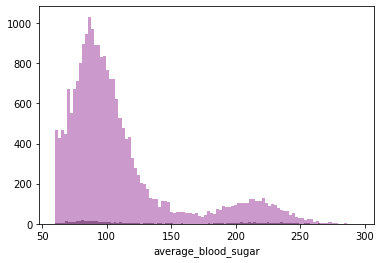

In [62]:
sns.distplot(stk_clean[stk_clean["stroke_in_2018"] == '1']["average_blood_sugar"], 
             kde = False, bins = 100, color = "black")
sns.distplot(stk_clean[stk_clean["stroke_in_2018"] == '0']["average_blood_sugar"], 
             kde = False, bins = 100, color = "purple")

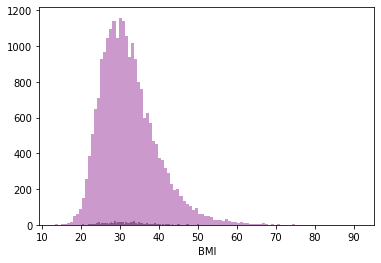

In [63]:
sns.distplot(stk_clean[stk_clean["stroke_in_2018"] == '1']["BMI"], 
             kde = False, bins = 100, color = "black")
sns.distplot(stk_clean[stk_clean["stroke_in_2018"] == '0']["BMI"], 
             kde = False, bins = 100, color = "purple")

### Treatments

Treatments have very few features, and thus we should not include them as part of the feature set is not ideal as it will reduce the sample set too significantly. We will only consider them for question 2. 

In [64]:
print(stk["TreatmentA"].unique())
print(stk["TreatmentB"].unique())
print(stk["TreatmentC"].unique())
print(stk["TreatmentD"].unique())

[nan  0.  1.]
[nan  0.  1.]
[nan  0.  1.]
[nan '0' '1']


In [65]:
print(stk["TreatmentA"].value_counts())
print(stk["TreatmentB"].value_counts())
print(stk["TreatmentC"].value_counts())
print(stk["TreatmentD"].value_counts())

0.0    990
1.0    219
Name: TreatmentA, dtype: int64
0.0    861
1.0    348
Name: TreatmentB, dtype: int64
0.0    969
1.0    240
Name: TreatmentC, dtype: int64
0    930
1    279
Name: TreatmentD, dtype: int64
